# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers[sentencepiece]
!pip install evaluate
!pip install bert-score
!pip install unbabel-comet
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.3 MB/s eta 0:00:00
 

In [3]:
import pandas
import os
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, DataCollatorForLanguageModeling, BertTokenizer, BertForMaskedLM, AutoModelForMaskedLM
import collections
from transformers.data.data_collator import tf_default_data_collator
from datasets import Dataset,load_dataset,DatasetDict
from scipy import stats
from contextlib import redirect_stdout
from bert_score import score,plot_example
from nltk.tokenize import word_tokenize
import scipy.spatial as sp
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import cosine_similarity
from evaluate import load
from scipy.spatial import distance
from sentence_transformers import SentenceTransformer, util
import math
import tensorflow as tf
import random
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Load Data
### Computed score vs human score correlation

 MQM-style annotations use a formula to automatically compute scores for each segment based on the errors identified.
The computed scores for each segment with a set of identified errors, E, is given by:

$s = 25 - \sum_{i \in E} w_i*e_i$


where $w_i$ is the penalty associated with the severity of the error and $e_i$ is the penalty associated with the type of error




In [4]:
# Load according to your choice of language language
lng= 'mr' # 'gu','hi', 'mr','ml','ta'

lang_res_path = os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng)
if not os.path.exists(lang_res_path):
    os.makedirs(lang_res_path)

with open(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng, 'computed_vs_human_correlation'+lng+'.txt'), 'a') as fp:
    pass

root_path = '/content/drive/MyDrive/Github/GenerationEval'
csv_file_path=os.path.join(root_path,'files',lng)
data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
data.rename(columns={"Human_scores": "human"}, inplace=True)
data.rename(columns={"Computed_scores": "computed"}, inplace=True)

computed= data['computed'].to_numpy()
human= data['human'].to_numpy()
computed[computed<0]=0
print("computed: ",np.argwhere(np.isnan(computed)))
human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))] #replacing missing /nan human scores with computed scores for valid calculation
spearmanr = stats.spearmanr(computed, human)
pearsonr = stats.pearsonr(computed, human)
kendalltau = stats.kendalltau(computed, human)
computed_human_corrfile = open(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng, 'computed_vs_human_correlation'+lng+'.txt'), 'w')
computed_human_corrfile.write("\n-----------------COMPUTED VS HUMAN CORRELATIONS-----------------\n\n") # A measure of the computed scores (as per the empirical formula) vs the human scores
computed_human_corrfile.flush()
with redirect_stdout(computed_human_corrfile):
    print("PearsonrResult =",end=' ',flush=True)
    print(pearsonr,flush=True)
    print(spearmanr,flush=True)
    print(kendalltau,flush=True)

computed_human_corrfile.close()


computed:  []


# BLEU & ROUGE-L

In [ ]:
%cd /content/drive/MyDrive/Github/NLG-evaluation

/content/drive/MyDrive/Github/NLG-evaluation


In [ ]:
rawhyp = open('/content/drive/MyDrive/Github/NLG-evaluation/temp_hyp.txt', "rb+")
rawref = open('/content/drive/MyDrive/Github/NLG-evaluation/temp_ref.txt', "rb+")

with open(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng, 'eval_results_'+lng+'.txt'), 'a') as fp:
    pass

rawres = open(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,'eval_results_'+lng+'.txt'),"rb+")

# contenthyp = rawhyp.read().split("\n")
# contentref = rawref.read().split("\n")
# contentres = rawres.read().split("\n")

rawhyp.seek(0)
rawhyp.truncate()
rawref.seek(0)
rawref.truncate()
rawres.seek(0)
rawres.truncate()

rawhyp.close()
rawref.close()
rawres.close()

In [ ]:
lang= ['gu','hi', 'mr','ml','ta']

references = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()


assert len(references) == len(hypotheses) , 'Please input equal number of Hypotheses and References'

ts =time.time()
for i in range(len(hypotheses)):

    temp_hyp_file = open('/content/drive/MyDrive/Github/NLG-evaluation/temp_hyp.txt', 'w')
    temp_ref_file = open('/content/drive/MyDrive/Github/NLG-evaluation/temp_ref.txt', 'w')
    temp_hyp_file.write(hypotheses[i])
    temp_hyp_file.flush()
    temp_ref_file.write(references[i])
    temp_ref_file.flush()

    !python /content/drive/MyDrive/Github/NLG-evaluation/run_eval.py --hypos /content/drive/MyDrive/Github/NLG-evaluation/temp_hyp.txt --refs /content/drive/MyDrive/Github/NLG-evaluation/temp_ref.txt -nM -nC -l 'guj'
    # temp_hyp_file.close()
    # temp_ref_file.close()
    te =time.time()
    if(i%5==0):
        print("time taken for "+str(i+1)+" files = "+ str(te-ts))

time taken for 1 files = 7.207693338394165
time taken for 6 files = 9.401909589767456
time taken for 11 files = 11.383557558059692
time taken for 16 files = 13.36178469657898
time taken for 21 files = 15.360893726348877
time taken for 26 files = 17.550588369369507
time taken for 31 files = 19.52957582473755
time taken for 36 files = 22.384246587753296
time taken for 41 files = 28.172362327575684
time taken for 46 files = 34.54758882522583
time taken for 51 files = 37.7097954750061
time taken for 56 files = 41.768821477890015
time taken for 61 files = 45.29780864715576
time taken for 66 files = 48.06813049316406
time taken for 71 files = 51.725276947021484
time taken for 76 files = 54.45526456832886
time taken for 81 files = 57.349321126937866
time taken for 86 files = 60.091235399246216
time taken for 91 files = 62.70203971862793
time taken for 96 files = 66.5943250656128
time taken for 101 files = 69.30683588981628
time taken for 106 files = 72.80533981323242
time taken for 111 files 

In [ ]:
b1_arr = np.empty(len(data)) #arrays for storing bleu1 results
b2_arr = np.empty(len(data)) #
b3_arr = np.empty(len(data)) #
b4_arr = np.empty(len(data)) #
rouge_arr = np.empty(len(data)) #array for storing rouge results

iter_b1 = iter_b2 =iter_b3=iter_b4=iter_rouge= 0


with open(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng, 'eval_results_'+lng+'.txt')) as bigfile:
    for lineno, line in enumerate(bigfile):
        if lineno % 5 == 0:
            if not line.isspace():
                rouge_score = line.split(":",1)[1].replace(" ","")
                rouge_arr[iter_rouge]=rouge_score
                iter_rouge+=1
        elif lineno % 5 == 1:
            bleu1_score = line.split(":",1)[1].replace(" ","")
            b1_arr[iter_b1]=bleu1_score
            iter_b1+=1
        elif lineno % 5 == 2:
            bleu2_score = line.split(":",1)[1].replace(" ","")
            b2_arr[iter_b2]=bleu2_score
            iter_b2+=1
        elif lineno % 5 == 3:
            bleu3_score = line.split(":",1)[1].replace(" ","")
            b3_arr[iter_b3]=bleu3_score
            iter_b3+=1
        else:
            bleu4_score = line.split(":",1)[1].replace(" ","")
            b4_arr[iter_b4]=bleu4_score
            iter_b4+=1


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'bleu1_'+lng), b1_arr, allow_pickle=True, fix_imports=True)
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'bleu2_'+lng), b2_arr, allow_pickle=True, fix_imports=True)
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'bleu3_'+lng), b3_arr, allow_pickle=True, fix_imports=True)
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'bleu4_'+lng), b4_arr, allow_pickle=True, fix_imports=True)
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'rouge_'+lng), rouge_arr, allow_pickle=True, fix_imports=True)

# SacreBLEU

In [ ]:
sacrebleu = load("sacrebleu")
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_sbleu = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
for i in range(len(hypotheses)):

    results = sacrebleu.compute(predictions=[hypotheses[i]], references=[references1[i]])
    results_sbleu[i] = results['score']
    te =time.time()
    if(i%50==0):
       print("time taken for "+str(i+1)+" files = "+ str(te-ts))


time taken for 1 files = 0.026095867156982422
time taken for 51 files = 0.4164845943450928
time taken for 101 files = 0.9036452770233154
time taken for 151 files = 1.3058927059173584


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'sacrebleu_'+lng), results_sbleu, allow_pickle=True, fix_imports=True)

# Low performing systems correlation

In [ ]:
lng= 'tamil'
root_path = '/content/drive/MyDrive/Github/GenerationEval'
csv_file_path=os.path.join(root_path,'files',lng)
data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
data_nllb.index = list(range(len(data),len(data)+200))
data_nllb['model'] = ['NLLB']*len(data_nllb)
data = data.append(data_nllb)
data.rename(columns={"Human_scores": "human"}, inplace=True)
data.rename(columns={"Computed_scores": "computed"}, inplace=True)
computed= data['computed'].to_numpy()
human= data['human'].to_numpy()
computed[computed<0]=0
human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]
models = data['model']


In [ ]:
model_sl = ['cvit_iiith','mBART','mT5']

# Note the above models shortlist changes based on language
# Refer below for high systems
# tamil: ['google_api','IndicTrans_Samanantar','bing_api','nllb']   #
# mal: ['google_api','IndicTrans_Samanantar','bing_api','nllb']
# mr: ['cvit_iiith','IndicTrans_Samanantar','bing_api','nllb']
# guj: ['google_api','IndicTrans_Samanantar','bing_api','nllb']
# hindi: ['google_api','IndicTrans_Samanantar','mT5','nllb']


#['IndicTrans_Samanantar','bing_api','cvit_iiith','google_api','mBART','mT5']
indsl = []
x = 0
for i in models:
  if i in model_sl:
    indsl.append(x)
  x+=1
#This is to add all NLLB outputs
# for i in range(200):
#   indsl.append(x)
#   x+=1
print(x)
print(len(indsl))

1725
765


In [ ]:
metric_types = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'sacrebleu', 'rouge', 'chrf_hf', 'ter_hf', 'avg_cossim', 'vector_extrema' , 'greedy_matching','laser', 'labse', 'mbert', 'distilbert', 'indic_bert', 'muril', 'prism', 'bleurt20','comet']
#metric_types = ['cometmqm','bleurt20','laser'] #'distilbert', 'mbert','muril','perplexity']

for metric_type in metric_types:
  try:
      indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric_type+'_'+lng+'.npy')
  except:
    print("Error: ", metric_type)
    continue
  metric_results=indic_results
  try:
      indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric_type+'_nllb_'+lng+'.npy')
  except:
    print("Error (NLLB): ", metric_type)
    continue

  #metric_results = metric_results + indic_results
  metric_results = np.append(metric_results,indic_results)
  correlations_dict = {'metric_type':metric_type , 'lang':lng}

  rho_spearmanr,pval = stats.spearmanr(metric_results[indsl], computed[indsl])
  rho_pearsonr,pval = stats.pearsonr(metric_results[indsl], computed[indsl])
  rho_kendalltau,pval = stats.kendalltau(metric_results[indsl], computed[indsl])

  # rho_spearmanr,pval = stats.spearmanr(metric_results[indsl], human[indsl])
  # rho_pearsonr,pval = stats.pearsonr(metric_results[indsl], human[indsl])
  # rho_kendalltau,pval = stats.kendalltau(metric_results[indsl], human[indsl])

  # rho_spearmanr,pval = stats.spearmanr(metric_results, computed)
  # rho_pearsonr,pval = stats.pearsonr(metric_results, computed)
  # rho_kendalltau,pval = stats.kendalltau(metric_results, computed)

  # rho_spearmanr,pval = stats.spearmanr(metric_results, computed)
  # rho_pearsonr,pval = stats.pearsonr(metric_results, computed)
  # rho_kendalltau,pval = stats.kendalltau(metric_results, computed)

  correlations_dict['pearsonr'] = rho_pearsonr
  correlations_dict['spearmanr'] = rho_spearmanr
  correlations_dict['kendalltau'] = rho_kendalltau

  #pprint.pprint(correlations_dict)
  #print(metric_type,rho_pearsonr,rho_spearmanr,rho_kendalltau)
  print("%.3f %.3f"% (rho_pearsonr ,rho_kendalltau))

print(model_sl)
print(lng)

#Tamil - 960
#Mal - 960
#Mar - 964
#guj - 960
#hindi - 957


0.325 0.215
0.271 0.200
0.178 0.166
0.120 0.162
0.249 0.191
0.346 0.236
0.361 0.248
-0.232 -0.196
0.186 0.140
0.347 0.233
0.401 0.278
0.081 0.067
0.338 0.276
0.443 0.304
0.455 0.308
0.439 0.310
0.449 0.320
-0.034 -0.052
0.467 0.362
0.508 0.400
['cvit_iiith', 'mBART', 'mT5']
tamil


# CHRF++/TER HF

In [ ]:
ter = load("chrf")   # Change to load("ter") for TER scores
results_chrf = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
for i in range(len(hypotheses)):

    results = ter.compute(predictions=[hypotheses[i]], references=[references1[i]])
    results_chrf[i] = results['score']
    te =time.time()
    if(i%50==0):
       print("time taken for "+str(i+1)+" files = "+ str(te-ts))


time taken for 1 files = 0.019629478454589844
time taken for 51 files = 0.2802121639251709
time taken for 101 files = 0.5539617538452148
time taken for 151 files = 0.8120715618133545


In [ ]:
# Change chrf_hf below to ter_hf for saving TER scores
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'chrf_hf_'+lng), results_chrf, allow_pickle=True, fix_imports=True)

#Frequency visualization

In [ ]:
data["Error1_Type"].unique()

##  Error type count plot

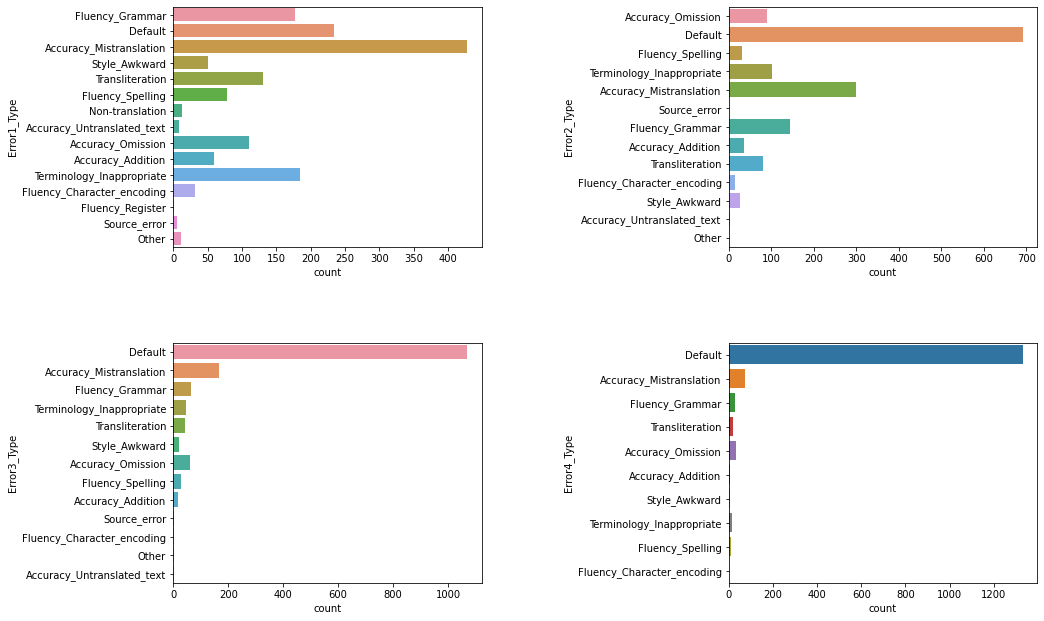

In [ ]:
fig, ax =plt.subplots(2,2,figsize=[15,10])
sns.countplot(y="Error1_Type",data=data,ax=ax[0][0])
sns.countplot(y="Error2_Type",data=data,ax=ax[0][1])
sns.countplot(y="Error3_Type",data=data,ax=ax[1][0])
sns.countplot(y="Error4_Type",data=data,ax=ax[1][1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)
plt.show()




##  Severity count plot for different error types


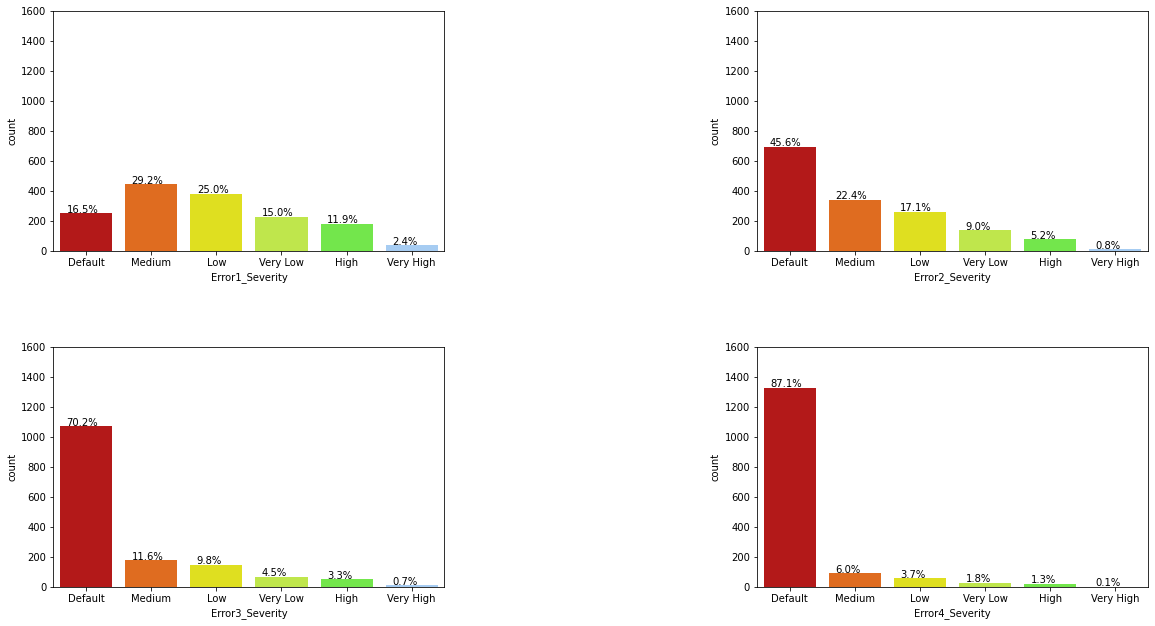

In [ ]:

# a plot with count of error severities
fig, ax =plt.subplots(2,2,figsize=[19,10])
data.Error1_Severity.fillna('Null', inplace=True)

# o = ['Default','Very Low','Low','Medium','High','Very High'].reverse()
o=data['Error2_Severity'].value_counts().index
p = ['#cc0000','#ff6600','#ffff00','#ccff33','#66ff33','#99ccff']
sns.countplot(x="Error1_Severity",data=data,palette=p,order=o,ax=ax[0][0])
sns.countplot(x="Error2_Severity",data=data,palette=p,order=o,ax=ax[0][1])
sns.countplot(x="Error3_Severity",data=data,palette=p,order=o,ax=ax[1][0])
sns.countplot(x="Error4_Severity",data=data,palette=p,order=o,ax=ax[1][1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)
total=len(data)*1.

for p in ax[0][0].patches:
        ax[0][0].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
for p in ax[0][1].patches:
        ax[0][1].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

for p in ax[1][0].patches:
        ax[1][0].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

for p in ax[1][1].patches:
        ax[1][1].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

custom_ylim=(0,1600)
plt.setp(ax, ylim=custom_ylim)


plt.show()







## Frequency Visualization for combined error types/severities


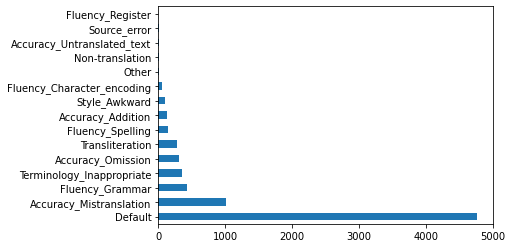

In [ ]:
appended_error_type_data = pandas.concat([data["Error1_Type"],data["Error2_Type"],data["Error3_Type"],data["Error4_Type"],data["Error5_Type"]],axis=0)
errors = appended_error_type_data.value_counts()
errors.plot(kind='barh')



## Severity count plot for all error types

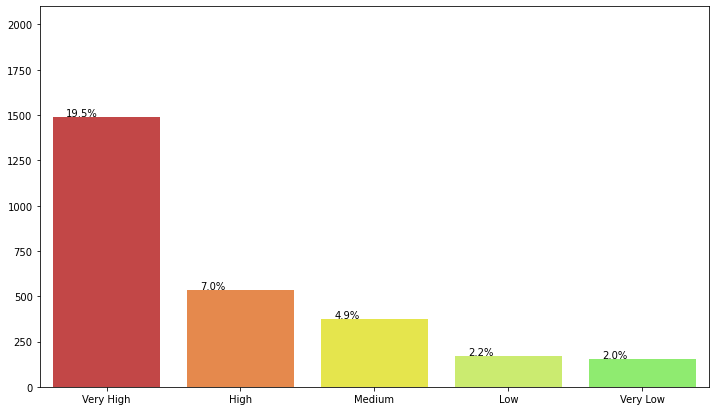

In [ ]:
appended_error_severity_data = pandas.concat([data["Error1_Severity"],data["Error2_Severity"],data["Error3_Severity"],data["Error4_Severity"],data["Error5_Severity"]],axis=0)
error_severity = appended_error_severity_data.value_counts()
error_severity.drop('Default',inplace=True)
total=len(appended_error_severity_data)
fig,ax=plt.subplots(1,1,figsize=[12,7])
p = ['#cc0000','#ff6600','#ffff00','#ccff33','#66ff33','#99ccff']
sns.barplot(x=error_severity.index, y=error_severity.values,palette=p,alpha=0.8)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

custom_ylim=(0,2100)
plt.setp(ax, ylim=custom_ylim)
plt.show()

# Stacked bar plot

<ipython-input-5-136187c2b531>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
<ipython-input-5-136187c2b531>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
<ipython-input-5-136187c2b531>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_

<Axes: title={'center': 'Error Types ordered by Severity : MARATHI'}, xlabel='Error_Type'>

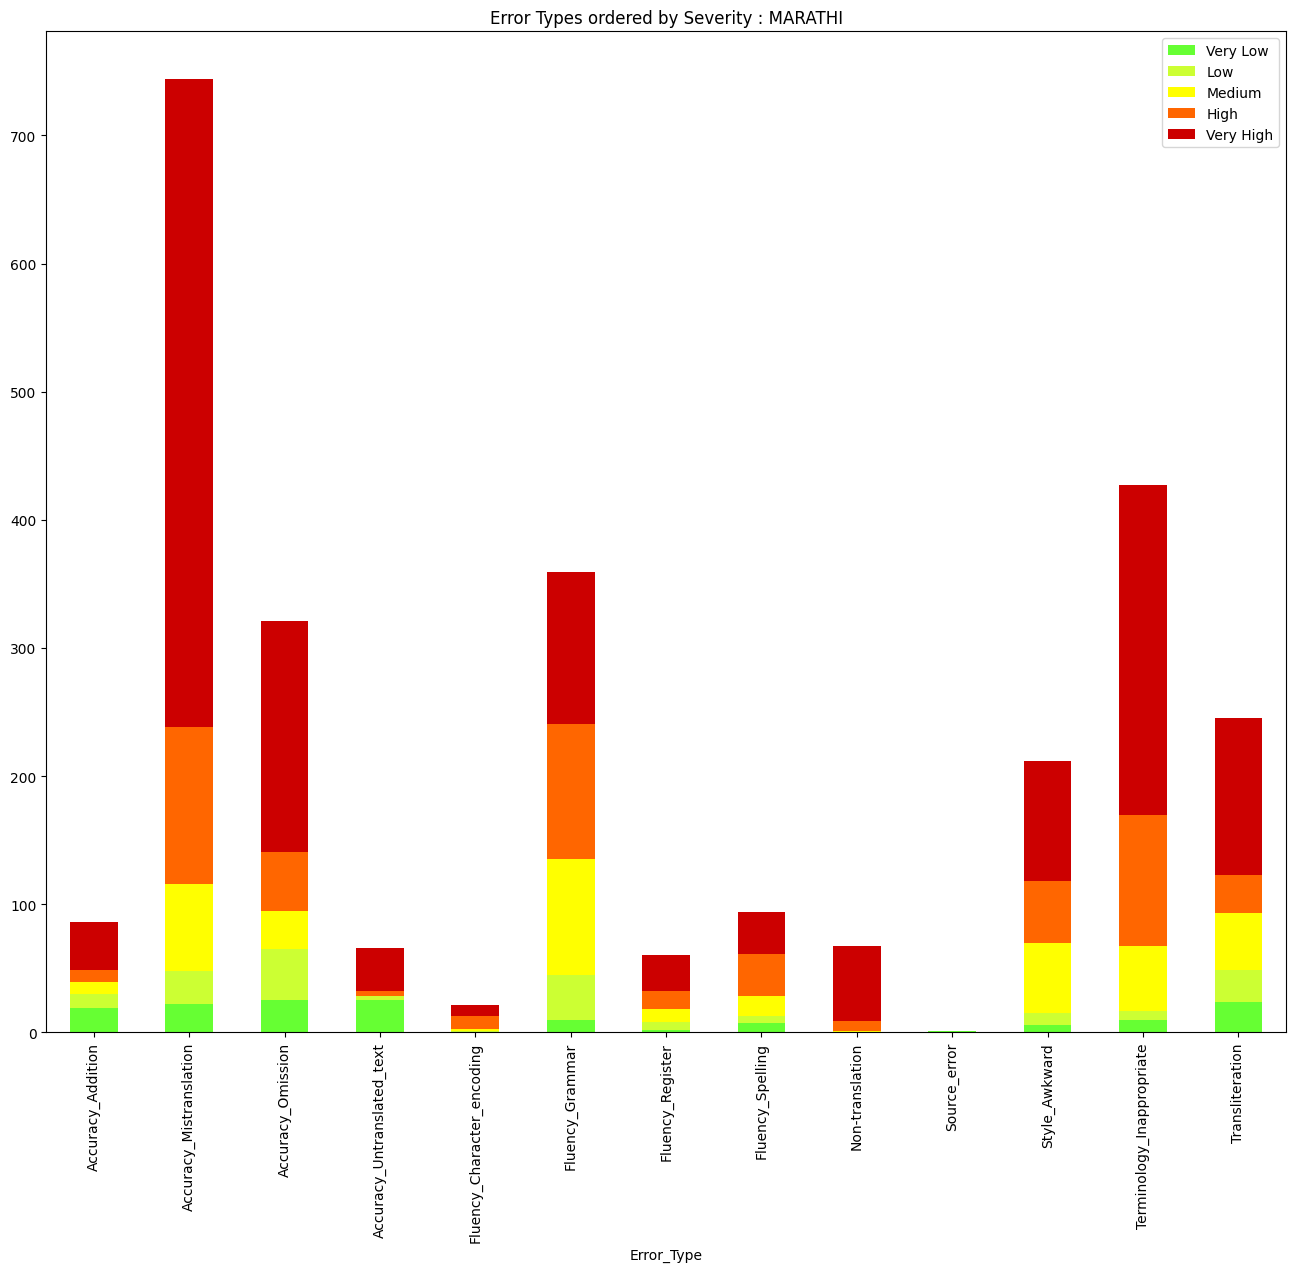

In [5]:
title_lang = 'Marathi'  #CHANGE, ONLY FOR TITLE
root_path = '/content/drive/MyDrive/Github/GenerationEval'
error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
severity_type = data['Error1_Severity'].append(data['Error2_Severity']).append(data['Error3_Severity']).append(data['Error4_Severity']).append(data['Error5_Severity']).reset_index(drop=True)
data2 = error_type.to_frame(name = 'Error_Type').join(severity_type.to_frame(name='Error_Severity'))
random = data2.groupby(['Error_Type','Error_Severity']).size()
matrix = random.to_frame().reset_index()
matrix.rename( columns={0 :'count'}, inplace=True )
matrix_new = pandas.pivot_table(matrix, values = 'count', index='Error_Type', columns = 'Error_Severity').reset_index().rename_axis(None, axis=1)
matrix_new = matrix_new[matrix_new['Error_Type'] != 'Default']
matrix_new.drop('Default', axis=1, inplace=True)
matrix_new = matrix_new.fillna(0)
cols = ['Error_Type','Very High','High','Medium','Low','Very Low']
cols.reverse()
matrix_new  = matrix_new[cols]
matrix_new.plot(x='Error_Type', kind='bar', stacked=True,color=['#66ff33', '#ccff33', '#ffff00', '#ff6600', '#cc0000'],title='Error Types ordered by Severity : '+title_lang.upper(),figsize=(16,13))


In [6]:
error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
severity_type = data['Error1_Severity'].append(data['Error2_Severity']).append(data['Error3_Severity']).append(data['Error4_Severity']).append(data['Error5_Severity']).reset_index(drop=True)
data2 = error_type.to_frame(name = 'Error_Type').join(severity_type.to_frame(name='Error_Severity'))
random = data2.groupby(['Error_Type','Error_Severity']).size()
matrix = random.to_frame().reset_index()
matrix.rename( columns={0 :'count'}, inplace=True )
matrix_new = pandas.pivot_table(matrix, values = 'count', index='Error_Type', columns = 'Error_Severity').reset_index().rename_axis(None, axis=1)
matrix_new = matrix_new[matrix_new['Error_Type'] != 'Default']
matrix_new.drop('Default', axis=1, inplace=True)
matrix_new = matrix_new.fillna(0)
print(matrix_new)
cols = ['Error_Type','Very High','High','Medium','Low','Very Low']
cols.reverse()
matrix_new  = matrix_new[cols]
print(matrix_new)


                    Error_Type   High   Low  Medium  Very High  Very Low
0            Accuracy_Addition   10.0  11.0     9.0       37.0      19.0
1      Accuracy_Mistranslation  122.0  26.0    68.0      506.0      22.0
2            Accuracy_Omission   46.0  40.0    30.0      180.0      25.0
3   Accuracy_Untranslated_text    4.0   3.0     0.0       34.0      25.0
5   Fluency_Character_encoding   10.0   1.0     2.0        8.0       0.0
6              Fluency_Grammar  106.0  35.0    90.0      118.0      10.0
7             Fluency_Register   14.0   6.0    10.0       28.0       2.0
8             Fluency_Spelling   33.0   6.0    15.0       33.0       7.0
9              Non-translation    8.0   0.0     1.0       58.0       0.0
10                Source_error    0.0   0.0     0.0        0.0       1.0
11               Style_Awkward   48.0   9.0    55.0       94.0       6.0
12   Terminology_Inappropriate  103.0   7.0    50.0      257.0      10.0
13             Transliteration   30.0  25.0    44.0

<ipython-input-6-821adfbee78f>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
<ipython-input-6-821adfbee78f>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
<ipython-input-6-821adfbee78f>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_

#KDE plots

## Scores per metric

In [ ]:
lang= ['gu','hi','mr','ml','ta']
metrics = ['indic_bert_','comet_','bleu1_','chrf_','vector_extrema_']
for metric in metrics:
  for lng in lang :
    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
    root_path = '/content/drive/MyDrive/Github/GenerationEval'
    csv_file_path=os.path.join(root_path,'files',lng)
    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data.rename(columns={"Human_scores": "human"}, inplace=True)
    data.rename(columns={"Computed_scores": "computed"}, inplace=True)
    computed= data['computed'].to_numpy()
    human= data['human'].to_numpy()
    computed[computed<0]=0
    human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]
    metric_results_scaled =(metric_results - np.min(metric_results)) / (np.max(metric_results) - np.min(metric_results))
    img_file_name_path1 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/image_results/",lng,lng+metric+"_normalized")
    plt1 = sns.kdeplot(data=metric_results_scaled,bw_adjust = 0.3)
    # plt1.suptitle('Normalized COMET-DA scores')
    plt1 = plt1.get_figure()
    plt1.savefig(img_file_name_path1+".png")
    plt1.clf()
    img_file_name_path3 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/image_results/",lng,lng+metric)
    plt3 = sns.kdeplot(data=metric_results,bw_adjust = 0.3)
    # plt3.fig.suptitle('COMET-DA scores')
    plt3 = plt3.get_figure()
    plt3.savefig(img_file_name_path3+".png")
    plt3.clf()
    img_file_name_path2 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/image_results/",lng,lng+"_human_computed_scores")
    plt2 = sns.kdeplot(data=data, x="human",bw_adjust = 0.5)
    plt2 = sns.kdeplot(data=data, x="computed",bw_adjust = 0.5)
    plt2 = plt2.get_figure()
    plt2.legend(labels=['Human Score', 'Computed score']) #title='Annotated Scores : '+lng, loc='upper left',
    plt2.savefig(img_file_name_path2+".png")
    plt2.clf()

<Figure size 432x288 with 0 Axes>

## Scatter plots


In [ ]:
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent],
                          width / self.num_stripes,
                          height,
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)),
                          transform=trans)
            stripes.append(s)
        return stripes

cmaps = [plt.cm.plasma]
cmap_labels = ["Density of scores (low  \u2192 high)"]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles,
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))

## Scatter plot for all languages for selected metrics

In [ ]:
lang= ['gu','hi','mr','ml','ta']
metrics = ['indic_bert_','comet_','chrf_hf_','vector_extrema_','sacrebleu_','ter_hf_','rouge_','bleurt20_']
mm = ['BERTScore','COMET-DA','CHRF++','Vector Extrema (IndicFT)','SacreBLEU','TER','ROUGE','BLEURT-20']

fig, ax = plt.subplots(len(lang), len(metrics), sharex=True, sharey=True, figsize=(15,10))
# fig.suptitle('')
langg= ['gu', 'hi','mr','ml','ta']


for i,lng in enumerate(lang):
  for j,metric in enumerate(metrics):
    lang_res_path = os.path.join('/content/drive/MyDrive/Github/GenerationEval/scatter_plots_final',lng)
    if not os.path.exists(lang_res_path):
       os.makedirs(lang_res_path)
    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
    root_path = '/content/drive/MyDrive/Github/GenerationEval'
    csv_file_path=os.path.join(root_path,'files',lng)
    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data.rename(columns={"Human_scores": "human"}, inplace=True)
    data.rename(columns={"Computed_scores": "computed"}, inplace=True)
    computed= data['computed'].to_numpy()
    human= data['human'].to_numpy()
    data1 = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
    data1.rename(columns={"Human_scores": "human"}, inplace=True) #Human_scores |  For tamil use :  #Human_Final_score (out of 25)
    data1.rename(columns={"Computed_scores": "computed"}, inplace=True) #Computed_scores  | For tamil use: #Computed_score1
    computed1= data1['computed'].to_numpy()
    human1= data1['human'].to_numpy()
    computed = np.append(computed,computed1)
    human = np.append(human, human1)
    computed[computed<0]=0

    human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

    #############################################

    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval_new.csv'))
    data.rename(columns={"ID (ignore_column)": "ids"}, inplace=True)
    ids = data['ids']
    ids1=ids.tolist()
    for n in range(1,201):
      ids1.append(n)

    ##################################################
    anno_indices_file=os.path.join(root_path,'files',lng)
    inds = pandas.read_csv(os.path.join(anno_indices_file,lng+'_nomBart.csv'),header=None)
    back_indsl = inds[0].tolist()
    for z in range(1,201):
      back_indsl.append(z)
    back_indsl = np.array(back_indsl)


    anno_inds = []
    co = 0

    for m in ids1:
      if m in back_indsl:
        anno_inds.append(co)
      co+=1;
    indsl = np.unique(np.array(anno_inds))
    indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric+'nllb_'+lng+'.npy')
    metric_results = np.append(metric_results,indic_results)

    ##################################################
    human = human[indsl]
    metric_results = metric_results[indsl]
    human_scores_scaled=(human - np.min(human)) / (np.max(human) - np.min(human))
    metric_results_scaled =(metric_results - np.min(metric_results)) / (np.max(metric_results) - np.min(metric_results))
    img_file_name_path1 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/scatter_plots_final/",lng,lng+"_human_vs_"+metric)
    plt1  = sns.kdeplot(x=human_scores_scaled, y= metric_results_scaled, ax = ax[i][j],color='r', shade=True, bw_adjust = 0.05, cmap="plasma",shade_lowest = False)
    ax[i][j].set_ylabel(langg[i],fontsize = 12)
    ax[i][j].set_yticks([0,1])



for k in range(len(mm)):
  ax[len(lang)-1][k].set(xlabel=mm[k])


img_file_name_path1 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/scatter_plots_final/scatter_plot.png")#,lng,lng+"_human_vs_"+metric)
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.013, 0.5])
clb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), cax=cbar_ax)
clb.ax.set_title('Density',fontsize=10)
plt1 = plt1.get_figure()
plt1.savefig(img_file_name_path1,bbox_inches='tight')
plt1.clf()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now

<Figure size 1080x720 with 0 Axes>

## Human vs Metric KDE

In [ ]:
lang= ['gu','hi','mr','ml','ta']
metrics = ['indic_bert_','comet_','bleu1_','chrf_','vector_extrema_','sacrebleu_','ter_','rouge_']
for metric in metrics:
  for lng in lang :
    lang_res_path = os.path.join('/content/drive/MyDrive/Github/GenerationEval/scatter_plots_v3',lng)
    if not os.path.exists(lang_res_path):
       os.makedirs(lang_res_path)
    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
    root_path = '/content/drive/MyDrive/Github/GenerationEval'
    csv_file_path=os.path.join(root_path,'files',lng)
    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data.rename(columns={"Human_scores": "human"}, inplace=True)
    data.rename(columns={"Computed_scores": "computed"}, inplace=True)
    computed= data['computed'].to_numpy()
    human= data['human'].to_numpy()
    computed[computed<0]=0
    human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]
    human_scores_scaled=(human - np.min(human)) / (np.max(human) - np.min(human))
    metric_results_scaled =(metric_results - np.min(metric_results)) / (np.max(metric_results) - np.min(metric_results))
    img_file_name_path1 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/scatter_plots_v3/",lng,lng+"_human_vs_"+metric)
    plt1 = sns.kdeplot(x=human_scores_scaled, y= metric_results_scaled,color='r', shade=True, bw_adjust = 0.05, cmap="viridis",shade_lowest = False)
    plt1 = plt1.get_figure()
    plt1.savefig(img_file_name_path1+".png")
    plt1.clf()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now

<Figure size 432x288 with 0 Axes>

# BERTScores

## 1.Indic-BERT

In [ ]:
bertscore = load("bertscore")
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_prec = np.empty(len(data))
results_rec= np.empty(len(data))
results_f1s = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
for i in range(len(hypotheses)):
    ts =time.time()
    #MODIFY LANGUAGE AS PER NEED
    results = bertscore.compute(predictions=[hypotheses[i]],references=[references1[i]],model_type ='ai4bharat/indic-bert',num_layers=4,lang=lng)
    results_prec[i] = results['precision'][0]
    results_rec[i] = results['recall'][0]
    results_f1s[i] = results['f1'][0]
    te =time.time()
    print("time taken for "+str(i+1)+" files = "+ str(te-ts))


Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/135M [00:00<?, ?B/s]

time taken for 1 files = 20.423776865005493
time taken for 2 files = 0.28115177154541016
time taken for 3 files = 0.15923714637756348
time taken for 4 files = 0.19149351119995117
time taken for 5 files = 0.1977245807647705
time taken for 6 files = 0.22524213790893555
time taken for 7 files = 0.22232747077941895
time taken for 8 files = 0.12987804412841797
time taken for 9 files = 0.20087814331054688
time taken for 10 files = 0.1128072738647461
time taken for 11 files = 0.062142372131347656
time taken for 12 files = 0.07066154479980469
time taken for 13 files = 0.10177206993103027
time taken for 14 files = 0.24378061294555664
time taken for 15 files = 0.10751771926879883
time taken for 16 files = 0.06943583488464355
time taken for 17 files = 0.1502819061279297
time taken for 18 files = 0.12452507019042969
time taken for 19 files = 0.26093435287475586
time taken for 20 files = 0.18268322944641113
time taken for 21 files = 0.1387162208557129
time taken for 22 files = 0.15551328659057617
t

In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'indic_bert_'+lng), results_f1s, allow_pickle=True, fix_imports=True)

## 2.MuRIL

In [ ]:
bertscore = load("bertscore")
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_prec = np.empty(len(data))
results_rec= np.empty(len(data))
results_f1s = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
for i in range(len(hypotheses)):
    ts =time.time()
    #MODIFY BELOW LANGUAGE
    results = bertscore.compute(predictions=[hypotheses[i]],references=[references1[i]],model_type ='google/muril-base-cased',num_layers=4,lang=lng)
    results_prec[i] = results['precision'][0]
    results_rec[i] = results['recall'][0]
    results_f1s[i] = results['f1'][0]
    te =time.time()
    if(i%500 ==0):
        print("time taken for "+str(i+1)+" files = "+ str(te-ts))


Downloading:   0%|          | 0.00/206 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

time taken for 1 files = 87.50289511680603


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'muril_'+lng), results_f1s, allow_pickle=True, fix_imports=True)

## 3.bert-base-multilingual-cased

In [ ]:
bertscore = load("bertscore")
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_prec = np.empty(len(data))
results_rec= np.empty(len(data))
results_f1s = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
for i in range(len(hypotheses)):

        #MODIFY LANGUAGE AS PER NEED
    results = bertscore.compute(predictions=[hypotheses[i]], references=[references1[i]], lang=lng,model_type ='bert-base-multilingual-cased' )
    results_prec[i] = results['precision'][0]
    results_rec[i] = results['recall'][0]
    results_f1s[i] = results['f1'][0]
    te =time.time()
    if(i%100==0):
       print("time taken for "+str(i+1)+" files = "+ str(te-ts))


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

time taken for 1 files = 32.753546953201294
time taken for 101 files = 81.07798552513123


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'mbert_'+lng), results_f1s, allow_pickle=True, fix_imports=True)

#distilbert-base-multilingual-cased




In [ ]:
bertscore = load("bertscore")
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_prec = np.empty(len(data))
results_rec= np.empty(len(data))
results_f1s = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
for i in range(len(hypotheses)):
    ts =time.time()
    #MODIFY LANGUAGE AS PER NEED
    results = bertscore.compute(predictions=[hypotheses[i]], references=[references1[i]], lang="gu",model_type ='distilbert-base-multilingual-cased' )
    results_prec[i] = results['precision'][0]
    results_rec[i] = results['recall'][0]
    results_f1s[i] = results['f1'][0]
    te =time.time()
    print("time taken for "+str(i+1)+" files = "+ str(te-ts))



Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/542M [00:00<?, ?B/s]

time taken for 1 files = 40.89645290374756
time taken for 2 files = 0.46091222763061523
time taken for 3 files = 0.28455591201782227
time taken for 4 files = 0.21808791160583496
time taken for 5 files = 0.22292685508728027
time taken for 6 files = 0.2721273899078369
time taken for 7 files = 0.38523411750793457
time taken for 8 files = 0.2618982791900635
time taken for 9 files = 0.29589414596557617
time taken for 10 files = 0.23067212104797363
time taken for 11 files = 0.123809814453125
time taken for 12 files = 0.13124632835388184
time taken for 13 files = 0.1771240234375
time taken for 14 files = 0.4654824733734131
time taken for 15 files = 0.21175670623779297
time taken for 16 files = 0.1510753631591797
time taken for 17 files = 0.26726388931274414
time taken for 18 files = 0.20763278007507324
time taken for 19 files = 0.4237399101257324
time taken for 20 files = 0.26997828483581543
time taken for 21 files = 0.2427983283996582
time taken for 22 files = 0.23334145545959473
time taken 

In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'distilbert_'+lng), results_f1s, allow_pickle=True, fix_imports=True)

# COMET

In [ ]:
comet_metric = load('comet') # COMET-DA, for this add config_name='wmt21-comet-mqm' for COMET_MQM
source = data['Source'].to_list()
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_mean = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
# for i in range(len(hypotheses)):

results = comet_metric.compute(predictions=hypotheses, references=references1, sources=source)
results= results['scores']
te =time.time()
print("time taken for "+len(data)+" files = "+ str(te-ts))


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'comet_'+lng), results_mean, allow_pickle=True, fix_imports=True)

# PRISM

In [ ]:
import sys
stdout = sys.stdout

In [ ]:
!git clone https://github.com/thompsonb/prism
%cd prism  #modify paths
!pip install -r requirements.txt

In [ ]:
%%bash

wget http://data.statmt.org/prism/m39v1.tar
tar xf m39v1.tar
export MODEL_DIR=m39v1/


In [ ]:
from prism import Prism   #uncomment when needed

prism = Prism(model_dir='/content/drive/MyDrive/Github/prism/m39v1/', lang='bn')

references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_segmented = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
results_segmented = prism.score(cand=hypotheses, ref=references1, segment_scores=True)
te =time.time()
print("time taken for 200 files = "+ str(te-ts) + " seconds")

In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'prism_'+lng), results_segmented, allow_pickle=True, fix_imports=True)

#BLEURT-20

In [ ]:
!pip install git+https://github.com/google-research/bleurt.git
!pip install datasets==2.10.0

In [ ]:
bleurt = load('bleurt', 'BLEURT-20') #comment when needed
references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
results_bleurt = np.empty(len(data))
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
assert len(references1) == len(hypotheses) , 'Please input equal number of Hypotheses and References'
ts =time.time()
for i in range(len(hypotheses)):

    results = bleurt.compute(predictions=[hypotheses[i]], references=[references1[i]])
    results_bleurt[i] = results['scores'][0]
    te =time.time()
    print("time taken for "+str(i+1)+" files = "+ str(te-ts))


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'bleurt20_'+lng), results_bleurt, allow_pickle=True, fix_imports=True)

#LASER-LM

## Laser cosine-sim

In [ ]:
!pip install laserembeddings
!python -m laserembeddings download-models

In [ ]:
from laserembeddings import Laser

laser = Laser()

references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
hyp_embeddings = laser.embed_sentences(hypotheses,lang=lngg) # lang is only used for tokenization
ref_embeddings = laser.embed_sentences(references1,lang=lngg)
cosine_sim_scores= np.empty(len(data))
for i in range(len(data)):
    cosine_sim_scores[i] = 1-distance.cosine(hyp_embeddings[i], ref_embeddings[i])


In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'laser_'+lng), cosine_sim_scores, allow_pickle=True, fix_imports=True)

##LASER-Manhattan sim



In [ ]:
# from laserembeddings import Laser

# laser = Laser()

references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()
hyp_embeddings = laser.embed_sentences(hypotheses,lang=lng) # lang is only used for tokenization
ref_embeddings = laser.embed_sentences(references1,lang=lng)
manhattan_sim_scores= np.empty(len(data))
for i in range(len(data)):
    manhattan_sim_scores[i] = -distance.cityblock(hyp_embeddings[i], ref_embeddings[i])



#LabSE

In [ ]:
model = SentenceTransformer('sentence-transformers/LaBSE') #uncomment when runtime restarts

references1 = data['Reference'].to_list()
hypotheses = data['Translation'].to_list()

hyp_embeddings_labse = model.encode(hypotheses)
ref_embeddings_labse = model.encode(references1)
cosine_sim_scores = np.empty(len(data))
for i in range(len(data)):

   cosine_sim_scores[i] = util.pytorch_cos_sim(hyp_embeddings_labse[i], ref_embeddings_labse[i])



In [ ]:
np.save(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results',lng,'labse_'+lng), cosine_sim_scores, allow_pickle=True, fix_imports=True)

# System level metrics

The following code prints the system level scores for all metrics, space seperated for each model in the order: IndicTrans-Samanantar, Bing API, CVIT-IIITH, Google API, mBART, mT5, NLLB

In [ ]:
def round_p(value, round_digits):
    return format(round(value,round_digits), "."+str(round_digits)+"f")


In [ ]:
metrics = ['bleu1_', 'bleu2_', 'bleu3_', 'bleu4_', 'sacrebleu_', 'rouge_', 'chrf_hf_', 'ter_hf_', 'avg_cossim_', 'vector_extrema_' , 'greedy_matching_', 'mbert_', 'distilbert_', 'indic_bert_', 'muril_', 'comet_', 'prism_', 'bleurt20_', 'laser_', 'labse_']
lang= ['gu'] #,'hi', 'mr','ml','ta']

for metric in metrics:
    print(metric,"\n")
    for lng in lang:
        metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
        indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric+'nllb_'+lng+'.npy')# data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))

        metric_results = np.append(metric_results,indic_results)
        root_path = '/content/drive/MyDrive/Github/GenerationEval'
        csv_file_path=os.path.join(root_path,'files',lng)
        data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
        data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
        data_nllb.index = list(range(len(data),len(data)+200))
        data_nllb['model'] = ['NLLB']*len(data_nllb)
        data = data.append(data_nllb)
        data.rename(columns={"Human_scores": "human"}, inplace=True)
        data.rename(columns={"Computed_scores": "computed"}, inplace=True)
        computed= data['computed'].to_numpy()
        human= data['human'].to_numpy()
        computed[computed<0]=0
        human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]
        data['index'] = data.index
        info = data.groupby("model")['index'].apply(list)
        model_info_dict = {'lang' : lng,'metric_type':metric}

        for model, ind_list in info.items():
          model_info_dict[model] = np.mean(human[ind_list])  # CHANGE TO metric_results[ind_list]


        print(round_p(model_info_dict['IndicTrans_Samanantar'],3), " ", round_p(model_info_dict['bing_api'],3)," ",round_p(model_info_dict['cvit_iiith'],3)," ", round_p(model_info_dict['google_api'],3)," ",round_p(model_info_dict['mBART'],3)," ",round_p(model_info_dict['mT5'],3)," ",round_p(model_info_dict['NLLB'],3)," "  )




bleu1_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
bleu2_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
bleu3_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
bleu4_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
sacrebleu_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
rouge_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
chrf_hf_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
ter_hf_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
avg_cossim_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
vector_extrema_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
greedy_matching_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
mbert_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
distilbert_ 

21.298   21.848   17.416   20.256   21.241   17.988   22.380  
indic_bert_ 

21.298   21.84

## Ratio plot

In [ ]:
def plot_clustered_stacked(dfall,labels=None, title="Multiple stacked bar plot ( lng = ta)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot.
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    # n_df = len(dfall)
    # n_col = len(dfall[0].columns)
    # n_ind = len(dfall[0].index)
    fig = plt.figure()
    lang = ['gu', 'hi', 'mr', 'ml', 'ta']
    # axe = fig.subplot(snum)
    # color = ['#880808','#A52A2A', '#E97451', '#F88379','#FAA0A0', '#0000FF', '#0066FF','#a0b4f0','#c6f2f6']
    color  = ['#222222' ,'#333333' ,'#444444' ,'#656565','#a9a9a9','#5c2f0e','#9a4e18','#d86e21','#e0813c' , '#eaa97a']
    # color.reverse()
    ax = [None]*5
    ax[0] = fig.add_subplot(1,5,1)
    ax[1] = fig.add_subplot(1,5,2)
    ax[2] = fig.add_subplot(1,5,3)
    ax[3] = fig.add_subplot(1,5,4)
    ax[4] = fig.add_subplot(1,5,5)

    # fig.subplots_adjust(bottom=0.3, wspace=0.33)   #########################################   newly added code

    #for df in dfall : # for each data frame
    # df = dfall.apply(lambda x : x/sum(x), axis=1)

    for i in range(len(dfall)): #no of languages indirectly
        dfall[i].plot(kind="bar",linewidth=0,stacked=True, ax=ax[i],legend=False,grid=False,color = color, figsize=(26,4), title =lang[i],rot=45,**kwargs)  # make bar plots
        ax[i].title.set_size(21)
        if(i==0):
          plt.setp(ax[i],  xticklabels=['Ref', 'Bing API', 'Google API','CVIT IIITH','IndicTrans','mT5','NLLB'],xticks= [0,1,2,3,4,5,6],ylabel = 'Ratio')
        else:
          plt.setp(ax[i],  xticklabels=['mBART', 'Bing API', 'Google API','CVIT IIITH','IndicTrans','mT5','NLLB'],xticks= [0,1,2,3,4,5,6])
        # plt.box(on=None)

        ax[i].tick_params(axis='x', which='major', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        # ax.spines['left'].set_visible(False)

    # handles, labels = ax[-1].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center')
    # plt.box(on=None)  ######new
    # plt.legend(frameon=False,bbox_to_anchor=(1, 1), fontsize=14)    #####  dont comment in original code

    plt.legend(frameon=False, bbox_to_anchor=(0.97, -0.4), fancybox=False, shadow=False, ncol = 10, fontsize =14)   ############newly added code, comment this and uncomment previous line for old functionality
    # loc='lower left'
    plt.savefig('/content/drive/MyDrive/Github/GenerationEval/ratio_plot/ratio_plot.png',bbox_inches='tight')
    plt.show()


In [ ]:
lang= ['gu','hi', 'mr','ml','ta']
# metrics = ['vector_extrema_','rouge_','ter_']
subplot_nums = [111,122,133,144,155,166]
# for metric in metrics:
ax = [None]*len(lang)
# totalerrors_per_system = [None]*7
dfall_arr =  [None]*len(lang)
for i,lng in enumerate(lang) :
  root_path = '/content/drive/MyDrive/Github/GenerationEval'
  csv_file_path=os.path.join(root_path,'files',lng)
  data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
  data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))

  data_nllb['model'] = ['NLLB']*len(data_nllb)
  data = data.append(data_nllb)
  data.rename(columns={"Human_scores": "human"}, inplace=True)
  data.rename(columns={"Computed_scores": "computed"}, inplace=True)
  computed= data['computed'].to_numpy()
  human= data['human'].to_numpy()
  computed[computed<0]=0
  human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

  ##############
  model_type  = data['model']
  error_class = ['Other']*len(data)
  error_type = {}

  fluency_substring = 'Fluency'
  accuracy_substring = 'Accuracy'
  terminology_substring = 'Terminology'
  nontranslation_substring = 'Non-translation'
  default_substring = 'Default'
  ind_dict ={'lang' : lng}
  fluency_indices = []
  accuracy_indices = []
  nontranslation_indices = []
  terminology_indices = []
  perfect_score_indices = []
  mixed_error_indices = []
  data.reset_index(drop=True, inplace= True)


  cols = ['Very High','High','Medium','Low','Very Low']


  models1 = data['model'].unique()
  models = {}
  error_types1 = ['Fluency', 'Accuracy', 'Non-translation', 'other']
  #error_types = {}
  for j in error_types1:
    res = pandas.DataFrame( columns=cols ,index=models1) #index = data['model'].unique()
    res.fillna(0,inplace=True)
    models[j] = res


  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
  severity_type = data['Error1_Severity'].append(data['Error2_Severity']).append(data['Error3_Severity']).append(data['Error4_Severity']).append(data['Error5_Severity']).reset_index(drop=True)
  modrep = data['model']
  model_repeat = modrep.append(modrep).append(modrep).append(modrep).append(modrep)

  for err,sev,mod in zip(error_type, severity_type, model_repeat):
    #res = models[mod]
    if fluency_substring in err:
      et = 'Fluency'
    elif accuracy_substring in err or terminology_substring in err:
      et = 'Accuracy'
    elif nontranslation_substring in err:
      et = 'Non-translation'
    elif 'Default' in err:
      continue
    else:
      et = 'other'
    res = models[et]
    if(sev!='Default'):
      res.loc[mod,sev]+=1
  models['Fluency'].rename(columns={'Very High':'Flu:Very High' ,'High':'Flu: High', 'Medium':'Flu:Medium', 'Low':'Flu:Low','Very Low':'Flu:Very Low'}, inplace = 'True')
  models['Accuracy'].rename(columns={'Very High':'Acc:Very High' ,'High':'Acc: High', 'Medium':'Acc:Medium', 'Low':'Acc:Low','Very Low':'Acc:Very Low'}, inplace = 'True')


  dfall = pandas.concat([models['Fluency'],models['Accuracy']],axis=1)
  dfall = dfall.apply(lambda x : x/sum(x), axis=1)
  dfall_arr[i]  = dfall


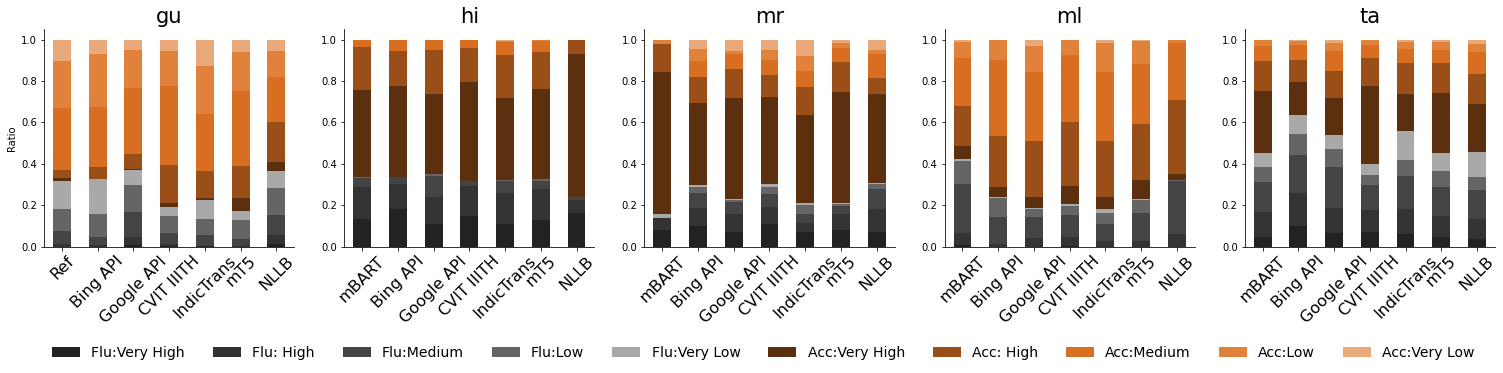

In [ ]:
plot_clustered_stacked(dfall_arr)

# Total errors per model

In [ ]:
#  total number of errors per model

lang= ['gu','hi', 'mr','ml','ta']
# metrics = ['vector_extrema_','rouge_','ter_']
subplot_nums = [111,122,133,144,155,166]
# for metric in metrics:
ax = [None]*len(lang)
# totalerrors_per_system = [None]*7
dfall_arr =  [None]*len(lang)
for i,lng in enumerate(lang) :
  root_path = '/content/drive/MyDrive/Github/GenerationEval'
  csv_file_path=os.path.join(root_path,'files',lng)
  data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
  data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))

  data_nllb['model'] = ['NLLB']*len(data_nllb)
  data = data.append(data_nllb)
  data.rename(columns={"Human_scores": "human"}, inplace=True)
  data.rename(columns={"Computed_scores": "computed"}, inplace=True)
  computed= data['computed'].to_numpy()
  human= data['human'].to_numpy()
  computed[computed<0]=0
  human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

  ##############
  model_type  = data['model']
  error_class = ['Other']*len(data)
  error_type = {}

  fluency_substring = 'Fluency'
  accuracy_substring = 'Accuracy'
  terminology_substring = 'Terminology'
  nontranslation_substring = 'Non-translation'
  default_substring = 'Default'
  ind_dict ={'lang' : lng}
  fluency_indices = []
  accuracy_indices = []
  nontranslation_indices = []
  terminology_indices = []
  perfect_score_indices = []
  mixed_error_indices = []
  data.reset_index(drop=True, inplace= True)


  cols = ['Very High','High','Medium','Low','Very Low']


  models1 = data['model'].unique()
  models = {}
  error_types1 = ['Fluency', 'Accuracy', 'Non-translation', 'other']
  #error_types = {}
  for j in error_types1:
    res = pandas.DataFrame( columns=cols ,index=models1) #index = data['model'].unique()
    res.fillna(0,inplace=True)
    models[j] = res


  error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
  severity_type = data['Error1_Severity'].append(data['Error2_Severity']).append(data['Error3_Severity']).append(data['Error4_Severity']).append(data['Error5_Severity']).reset_index(drop=True)
  modrep = data['model']
  model_repeat = modrep.append(modrep).append(modrep).append(modrep).append(modrep)

  for err,sev,mod in zip(error_type, severity_type, model_repeat):
    #res = models[mod]
    if fluency_substring in err:
      et = 'Fluency'
    elif accuracy_substring in err or terminology_substring in err:
      et = 'Accuracy'
    elif nontranslation_substring in err:
      et = 'Non-translation'
    elif 'Default' in err:
      continue
    else:
      et = 'other'
    res = models[et]
    if(sev!='Default'):
      res.loc[mod,sev]+=1
  models['Fluency'].rename(columns={'Very High':'Fluency:Very High' ,'High':'Fluency: High', 'Medium':'Fluency:Medium', 'Low':'Fluency:Low','Very Low':'Fluency:Very Low'}, inplace = 'True')
  models['Accuracy'].rename(columns={'Very High':'Accuracy:Very High' ,'High':'Accuracy: High', 'Medium':'Accuracy:Medium', 'Low':'Accuracy:Low','Very Low':'Accuracy:Very Low'}, inplace = 'True')

  # added model['Non-translation'] to below line
  dfall = pandas.concat([models['Fluency'],models['Accuracy'],models['Non-translation']],axis=1)
  # dfall = dfall.apply(lambda x : x/sum(x), axis=1)
  dfall_arr[i]  = dfall


In [ ]:
dfall_arr[0]

,Fluency:Very High,Fluency: High,Fluency:Medium,Fluency:Low,Fluency:Very Low,Accuracy:Very High,Accuracy: High,Accuracy:Medium,Accuracy:Low,Accuracy:Very Low,Very High,High,Medium,Low,Very Low
mBART,0,4,23,39,49,5,13,108,83,37,0,0,0,0,0
bing_api,0,2,10,31,46,0,15,80,69,19,0,0,0,0,0
google_api,4,17,51,56,32,2,30,138,79,21,0,0,0,0,0
cvit_iiith,1,6,32,51,25,13,112,231,104,33,1,0,0,0,0
IndicTrans_Samanantar,1,0,16,23,27,4,38,83,70,38,0,0,0,0,0
mT5,0,1,17,42,19,29,73,166,89,27,0,0,0,0,0
NLLB,2,7,15,20,13,7,30,34,19,9,0,0,0,0,0


In [ ]:
l = dfall_arr[0].sum(axis=1)#/dfall_arr[0].sum(axis=1)
print(l)
for a in l.values:
  print(a)


mBART                    361
bing_api                 272
google_api               430
cvit_iiith               609
IndicTrans_Samanantar    300
mT5                      463
NLLB                     156
dtype: int64
361
272
430
609
300
463
156


In [ ]:
#error_type  = data['Error1_Type'].append(data['Error2_Type']).append(data['Error3_Type']).append(data['Error4_Type']).append(data['Error5_Type']).reset_index(drop=True)
# we are interested in error distribution scores per model
info = data.groupby("model")['index'].apply(list)
error_type = {}

for i in range(5):
  stri = "Error" + str(i+1) +"_Type"
  error_type[i] = data[stri]

fluency_substring = 'Fluency'
accuracy_substring = 'Accuracy'
terminology_substring = 'Terminology'
default_substring = 'Default'
ind_dict ={'lang' : lng}
fluency_indices = []
accuracy_indices = []
terminology_indices = []
perfect_score_indices = []
mixed_error_indices = []
data.reset_index(drop=True, inplace= True)
#perfect_score_indices = data.index[data['human']==25].tolist()

for i in range(len(error_type[0])):
  fluency_count=0
  acc_count=0
  default_count=0
  for j in range(5):
    errortype = error_type[j][i].split("_")
    if fluency_substring in errortype:
          fluency_count+=1
          #fluency_indices.append(i%1525)
    if accuracy_substring in errortype or terminology_substring in errortype:
          acc_count+=1
          #accuracy_indices.append(i%1525)
    if default_substring in errortype:
          default_count+=1
    # if style
    # if(terminology_substring in errortype):
    #       terminology_indices.append(i%1525)
  if default_count == 5:
    #means no errors
    perfect_score_indices.append(i)

  elif acc_count + default_count == 5:
    accuracy_indices.append(i)
    # there were only accuracy errors
    # fluency_indices.append(i)
  elif fluency_count + default_count == 5:
    # accuracy_indices.append(i)
    fluency_indices.append(i)
  else:
    mixed_error_indices.append(i)
ind_dict['Fluency_based_errors_indices']  = np.unique(np.array(fluency_indices))
ind_dict['Accuracy_based_errors_indices']  = np.unique(np.array(accuracy_indices))
#ind_dict['NIL_errors_indices'] = perfect_score_indices
print(len(mixed_error_indices))
print(len(accuracy_indices))
print(len(fluency_indices))
print(len(perfect_score_indices))
print(len(error_type[0]))


945
252
284
44
1525


# Fluency & Accuracy error analysis

The below code outputs fluency and accuracy correlations for metrics for all 5 languages

In [ ]:
import warnings
warnings.filterwarnings("ignore")


lang= ['gu','hi', 'mr','ml','ta']
metrics = ['bleu1_', 'bleu2_', 'bleu3_', 'bleu4_', 'sacrebleu_', 'rouge_', 'chrf_hf_', 'ter_hf_', 'avg_cossim_', 'vector_extrema_' , 'greedy_matching_', 'mbert_', 'distilbert_', 'indic_bert_', 'muril_', 'comet_', 'prism_', 'bleurt20_', 'laser_', 'labse_']

for metric in metrics:
  for lng in lang :
    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
    indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric+'nllb_'+lng+'.npy')# data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))

    metric_results = np.append(metric_results,indic_results)
    root_path = '/content/drive/MyDrive/Github/GenerationEval'
    csv_file_path=os.path.join(root_path,'files',lng)
    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
    data_nllb.index = list(range(len(data),len(data)+200))
    data_nllb['model'] = ['NLLB']*len(data_nllb)
    data = data.append(data_nllb)
    data.rename(columns={"Human_scores": "human"}, inplace=True)
    data.rename(columns={"Computed_scores": "computed"}, inplace=True)
    computed= data['computed'].to_numpy()
    human= data['human'].to_numpy()
    computed[computed<0]=0
    human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

    error_type = {}
    for i in range(5):
      stri = "Error" + str(i+1) +"_Type"
      error_type[i] = data[stri]

    fluency_substring = 'Fluency'
    accuracy_substring = 'Accuracy'
    terminology_substring = 'Terminology'
    default_substring = 'Default'
    ind_dict ={'lang' : lng}
    fluency_indices = []
    accuracy_indices = []
    terminology_indices = []
    perfect_score_indices = []
    mixed_error_indices = []
    data.reset_index(drop=True, inplace= True)
    zero_score_indices = data.index[data['human']==0].tolist()

    for i in range(len(error_type[0])):
      fluency_count=0
      acc_count=0
      default_count=0
      for j in range(5):
        errortype = error_type[j][i].split("_")
        if fluency_substring in errortype:
              fluency_count+=1
        if accuracy_substring in errortype or terminology_substring in errortype:
              acc_count+=1
        if default_substring in errortype:
              default_count+=1
      if default_count == 5:
        #means no errors
        perfect_score_indices.append(i)

      elif acc_count + default_count == 5:
        accuracy_indices.append(i)
        # there were only accuracy errors
        # fluency_indices.append(i)
      elif fluency_count + default_count == 5:
        # accuracy_indices.append(i)
        fluency_indices.append(i)
      else:
        mixed_error_indices.append(i)
    ind_dict['Fluency_based_errors_indices']  = np.unique(np.array(fluency_indices+perfect_score_indices))
    ind_dict['Accuracy_based_errors_indices']  = np.unique(np.array(accuracy_indices+perfect_score_indices))

    correlations_dict = {'metric_type':metric , 'lang':lng}
    rho_spearmanr,pval = stats.spearmanr(metric_results[ind_dict['Fluency_based_errors_indices']], human[ind_dict['Fluency_based_errors_indices']])
    rho_pearsonr,pval = stats.pearsonr(metric_results[ind_dict['Fluency_based_errors_indices']], human[ind_dict['Fluency_based_errors_indices']])
    rho_kendalltau,pval = stats.kendalltau(metric_results[ind_dict['Fluency_based_errors_indices']], human[ind_dict['Fluency_based_errors_indices']])

    correlations_dict['spearmanr'] = rho_spearmanr
    correlations_dict['pearsonr'] = rho_pearsonr
    correlations_dict['kendalltau'] = rho_kendalltau
    correlations_dict['len(fluency_errors_indices)'] = len(ind_dict['Fluency_based_errors_indices'])


    # print(round(correlations_dict['pearsonr'],3), " ", round(correlations_dict['kendalltau'],3)," ", end = '')
    print("########## FLUENCY Correlations : "+lng+"  ##############\n")
    print(correlations_dict)

    # !! IMPORTANT!! RUN below code once done with printing Fluency scores
    # print("\n\n########## ACCURACY Correlations : "+lng+"  ##############\n")

    # correlations_dict = {'metric_type':metric , 'lang':lng}
    # rho_spearmanr,pval = stats.spearmanr(metric_results[ind_dict['Accuracy_based_errors_indices']], human[ind_dict['Accuracy_based_errors_indices']])
    # rho_pearsonr,pval = stats.pearsonr(metric_results[ind_dict['Accuracy_based_errors_indices']], human[ind_dict['Accuracy_based_errors_indices']])
    # rho_kendalltau,pval = stats.kendalltau(metric_results[ind_dict['Accuracy_based_errors_indices']], human[ind_dict['Accuracy_based_errors_indices']])

    # correlations_dict['spearmanr'] = rho_spearmanr
    # correlations_dict['pearsonr'] = rho_pearsonr
    # correlations_dict['kendalltau'] = rho_kendalltau
    # print(round(correlations_dict['pearsonr'],3), " ", round(correlations_dict['kendalltau'],3)," ", end = '')

    # print(correlations_dict['pearsonr'], " ", correlations_dict['kendalltau'])
    # print()

  print()


In [ ]:
error_type[0].unique()

array(['Default', 'Accuracy_Mistranslation', 'Style_Awkward',
       'Transliteration', 'Fluency_Spelling', 'Non-translation',
       'Accuracy_Untranslated_text', 'Accuracy_Omission',
       'Accuracy_Addition', 'Terminology_Inappropriate',
       'Fluency_Grammar', 'Fluency_Character_encoding',
       'Fluency_Register', 'Source_error', 'Other'], dtype=object)

# Perfect scores ablation

<ipython-input-36-1e54c7e2b392>:106: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if(split_zsi[j] != np.array([])):
<ipython-input-36-1e54c7e2b392>:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(split_zsi[j] != np.array([])):
<ipython-input-36-1e54c7e2b392>:117: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if(split_pzsi[j] != np.array([])):
<ipython-input-36-1e54c7e2b392>:117: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(split_pzsi[j] != np.array([])):
<ipython-input-36-1e54c7e2b392>:106: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will resu

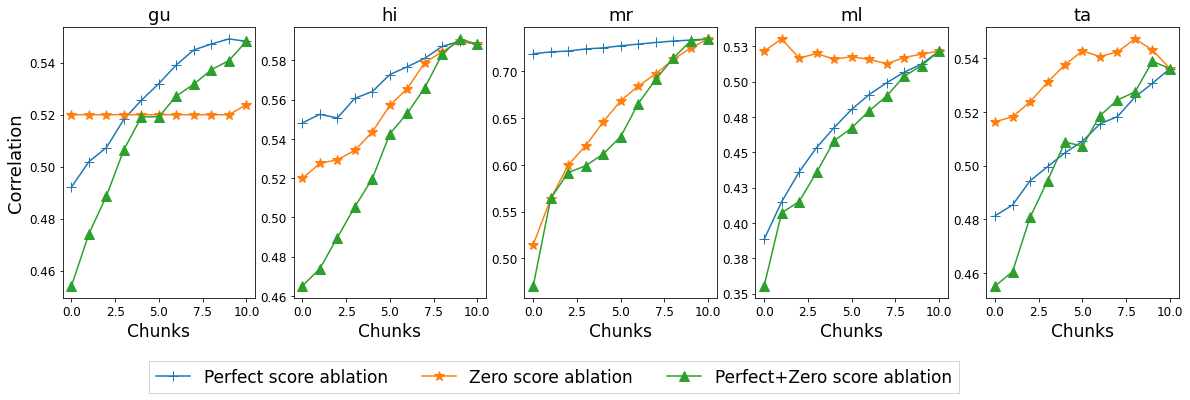

In [ ]:
from matplotlib.ticker import FormatStrFormatter



def split_add_rem_at_end(xs,n):
    chunk_size , rem_size= int(len(xs)/n), len(xs)%n
    nchunks = [None]*n
    i=j=0
    while(j<n):
        nchunks[j] = xs[i:i+chunk_size]
        i=i+chunk_size
        j+=1
    if(rem_size):
        nchunks[n-1] = np.append(nchunks[n-1], xs[i:len(xs)])
    return nchunks




fig,ax = plt.subplots(1,5,figsize=(20,5))#,sharex=True,sharey=True)

lang = ['guj', 'hindi', 'mr', 'mal', 'tamil']
langg = ['gu', 'hi', 'mr', 'ml', 'ta']
metric  =  'comet_'

# axe = fig.subplot(snum)
# color = ['#880808','#A52A2A', '#E97451', '#F88379','#FAA0A0', '#0000FF', '#0066FF','#a0b4f0','#c6f2f6']
color  = ['#222222' ,'#333333' ,'#444444' ,'#656565','#a9a9a9','#5c2f0e','#9a4e18','#d86e21','#e0813c' , '#eaa97a']
# color.reverse()
# ax = [None]*5
# ax[0] = fig.add_subplot(1,5,1)
# ax[1] = fig.add_subplot(1,5,2)
# ax[2] = fig.add_subplot(1,5,3)
# ax[3] = fig.add_subplot(1,5,4)
# ax[4] = fig.add_subplot(1,5,5)

for i,lng in enumerate(lang):
    metric  =  'comet_'
    root_path = '/content/drive/MyDrive/Github/GenerationEval'
    csv_file_path=os.path.join(root_path,'files',lng)

    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
    indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric+'nllb_'+lng+'.npy')# data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    metric_scores_all = np.append(metric_results,indic_results)
    csv_file_path=os.path.join(root_path,'files',lng)
    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
    data_nllb['model'] = ['NLLB']*len(data_nllb)
    data = data.append(data_nllb)

    # data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data.rename(columns={"Human_scores": "human"}, inplace=True)
    data.rename(columns={"Computed_scores": "computed"}, inplace=True)
    computed= data['computed'].to_numpy()
    human= data['human'].to_numpy()
    computed[computed<0]=0
    human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

    perfect_score_indices = np.where((data['human']>=23) & (data['human']<=25))[0]  #data.index[data['human']==25].tolist()
    zero_score_indices = np.where((data['human']>=0) & (data['human']<=2))[0]   #data.index[data['human']==0].tolist()
    zero_perfect_score_indices = np.sort(np.unique(np.append(perfect_score_indices,zero_score_indices)))
    split_psi = split_add_rem_at_end(perfect_score_indices,10)
    split_zsi = split_add_rem_at_end(zero_score_indices,10)
    split_pzsi = split_add_rem_at_end(zero_perfect_score_indices,10)

    split_psi.insert(0,np.array([]))
    split_zsi.insert(0,np.array([]))
    split_pzsi.insert(0,np.array([]))

    p_corr_abl_psi = np.empty(len(split_psi))
    s_corr_abl_psi = np.empty(len(split_psi))
    kt_corr_abl_psi = np.empty(len(split_psi))

    p_corr_abl_zsi = np.empty(len(split_zsi))
    s_corr_abl_zsi = np.empty(len(split_zsi))
    kt_corr_abl_zsi = np.empty(len(split_zsi))

    p_corr_abl_pzsi = np.empty(len(split_pzsi))
    s_corr_abl_pzsi = np.empty(len(split_pzsi))
    kt_corr_abl_pzsi = np.empty(len(split_pzsi))

    no_perfect_score_indices = np.setdiff1d(np.arange(len(data)), perfect_score_indices)
    no_zero_score_indices = np.setdiff1d(np.arange(len(data)), zero_score_indices)
    no_zero_perfect_score_indices = np.setdiff1d(np.arange(len(data)), zero_perfect_score_indices)

    computed_scores = computed[no_perfect_score_indices]
    # computed_scores = computed_scores_wo_ps.copy()

    # metric_scores_all= np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))

    metric_scores = metric_scores_all[no_perfect_score_indices]
    # metric_scores  = metric_scores_wo_ps.copy()

    for j in range(len(split_psi)):
      if(split_psi[j].size != 0):
            metric_scores = np.append(metric_scores, metric_scores_all[split_psi[j]])
            computed_scores = np.append(computed_scores,computed[split_psi[j]])
      p_corr_abl_psi[j],_ =  stats.pearsonr(metric_scores,computed_scores)
      s_corr_abl_psi[j],_ =  stats.spearmanr(metric_scores,computed_scores)
      kt_corr_abl_psi[j],_ =  stats.kendalltau(metric_scores,computed_scores)

    computed_scores = computed[no_zero_score_indices]
    metric_scores = metric_scores_all[no_zero_score_indices]

    for j in range(len(split_zsi)):
      if(split_zsi[j] != np.array([])):
            metric_scores = np.append(metric_scores, metric_scores_all[split_zsi[j]])
            computed_scores = np.append(computed_scores,computed[split_zsi[j]])
      p_corr_abl_zsi[j],_ =  stats.pearsonr(metric_scores,computed_scores)
      s_corr_abl_zsi[j],_ =  stats.spearmanr(metric_scores,computed_scores)
      kt_corr_abl_zsi[j],_ =  stats.kendalltau(metric_scores,computed_scores)

    computed_scores = computed[no_zero_perfect_score_indices]
    metric_scores = metric_scores_all[no_zero_perfect_score_indices]

    for j in range(len(split_pzsi)):
      if(split_pzsi[j] != np.array([])):
            metric_scores = np.append(metric_scores, metric_scores_all[split_pzsi[j]])
            computed_scores = np.append(computed_scores,computed[split_pzsi[j]])
      p_corr_abl_pzsi[j],_ =  stats.pearsonr(metric_scores,computed_scores)
      s_corr_abl_pzsi[j],_ =  stats.spearmanr(metric_scores,computed_scores)
      kt_corr_abl_pzsi[j],_ =  stats.kendalltau(metric_scores,computed_scores)

    #below 3 lines are part of the odl code
    # ax[i].scatter(x=np.arange(len(p_corr_abl_psi)),y=p_corr_abl_psi, s=10, c='b', marker="+", label='Perfect score ablation')
    # ax[i].scatter(x=np.arange(len(p_corr_abl_zsi)),y=p_corr_abl_zsi,s=10, c='r', marker="*", label='Zero score ablation')
    # ax[i].scatter(x=np.arange(len(p_corr_abl_pzsi)),y=p_corr_abl_pzsi,s=10, c='g', marker="o", label='Perfect+Zero score ablation')

    ax[i].plot(np.arange(len(p_corr_abl_psi)),p_corr_abl_psi, marker = '+',markersize = 10 , label='Perfect score ablation')
    ax[i].plot(np.arange(len(p_corr_abl_zsi)),p_corr_abl_zsi, marker = '*', markersize = 10,  label='Zero score ablation')
    ax[i].plot(np.arange(len(p_corr_abl_pzsi)),p_corr_abl_pzsi,marker = '^',markersize = 10  , label='Perfect+Zero score ablation')

    ax[i].set_title(langg[i],fontsize=18)
    ax[i].set_xlabel('Chunks',fontsize=17)
    # plt.setp(ax[i], xticklabels=XL,xticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    ax[i].tick_params(axis='y', labelsize=12)   # y tick labels
    ax[i].tick_params(axis='x', labelsize=12)   # y tick labels
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ax[i].set_yticks([0.3,0.4,0.5,0.6,0.7])
    # elif (i==1):
    # if (i==0||i==3||i==4):
    #   ax[i].set_yticks([0.35,0.4,0.45,0.5,0.55])
    # elif (i==1):
    #   ax[i].set_yticks([0.5,0.55,0.6,0.65,0.7])


    # set_title('ax1 title')

ax[0].set_ylabel("Correlation",fontsize=18)
plt.legend(bbox_to_anchor=(-0.1, -0.2), fancybox=False, shadow=False, ncol = 3, fontsize =17)   ############newly added code, comment this and uncomment previous line for old functionality
img_file_name_path = os.path.join("/content/drive/MyDrive/Github/GenerationEval/corr_plots/pzablation_all_with_mbart_1725")

plt.savefig(img_file_name_path+".png",bbox_inches='tight')
plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



 {'lang': 'guj', 'Perfect score count': 250, 'Zero score count': 17, 'Perfect+Zero score count': 267}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



 {'lang': 'hindi', 'Perfect score count': 333, 'Zero score count': 61, 'Perfect+Zero score count': 394}

 {'lang': 'mr', 'Perfect score count': 99, 'Zero score count': 25, 'Perfect+Zero score count': 124}

 {'lang': 'mal', 'Perfect score count': 255, 'Zero score count': 30, 'Perfect+Zero score count': 285}

 {'lang': 'tamil', 'Perfect score count': 52, 'Zero score count': 24, 'Perfect+Zero score count': 76}


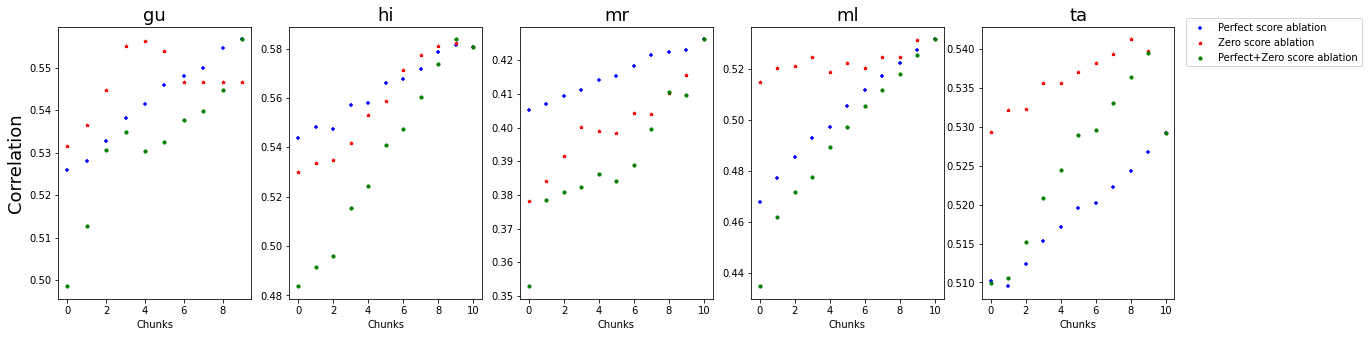

In [ ]:
def split_add_rem_at_end(xs,n):
    chunk_size , rem_size= int(len(xs)/n), len(xs)%n
    nchunks = [None]*n
    i=j=0
    while(j<n):
        nchunks[j] = xs[i:i+chunk_size]
        i=i+chunk_size
        j+=1
    if(rem_size):
        nchunks[n-1] = np.append(nchunks[n-1], xs[i:len(xs)])
    return nchunks




fig,ax = plt.subplots(1,5,figsize=(20,5))#,sharex=True,sharey=True)
lang = ['guj', 'hindi', 'mr', 'mal', 'tamil']
langg = ['gu', 'hi', 'mr', 'ml', 'ta']
metric  =  'comet_'

# axe = fig.subplot(snum)
# color = ['#880808','#A52A2A', '#E97451', '#F88379','#FAA0A0', '#0000FF', '#0066FF','#a0b4f0','#c6f2f6']
color  = ['#222222' ,'#333333' ,'#444444' ,'#656565','#a9a9a9','#5c2f0e','#9a4e18','#d86e21','#e0813c' , '#eaa97a']
# color.reverse()
# ax = [None]*5
# ax[0] = fig.add_subplot(1,5,1)
# ax[1] = fig.add_subplot(1,5,2)
# ax[2] = fig.add_subplot(1,5,3)
# ax[3] = fig.add_subplot(1,5,4)
# ax[4] = fig.add_subplot(1,5,5)

for i,lng in enumerate(lang):
    metric  =  'comet_'
    root_path = '/content/drive/MyDrive/Github/GenerationEval'
    csv_file_path=os.path.join(root_path,'files',lng)
    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
    data.rename(columns={"Human_scores": "human"}, inplace=True)
    data.rename(columns={"Computed_scores": "computed"}, inplace=True)
    computed= data['computed'].to_numpy()
    human= data['human'].to_numpy()
    data1 = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
    data1.rename(columns={"Human_scores": "human"}, inplace=True) #Human_scores |  For tamil use :  #Human_Final_score (out of 25)
    data1.rename(columns={"Computed_scores": "computed"}, inplace=True) #Computed_scores  | For tamil use: #Computed_score1
    computed1= data1['computed'].to_numpy()
    human1= data1['human'].to_numpy()
    computed = np.append(computed,computed1)
    human = np.append(human, human1)
    computed[computed<0]=0

    human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

    #############################################

    data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval_new.csv'))
    data.rename(columns={"ID (ignore_column)": "ids"}, inplace=True)
    ids = data['ids']
    ids1=ids.tolist()
    for n in range(1,201):
      ids1.append(n)

    ##################################################
    anno_indices_file=os.path.join(root_path,'files',lng)
    inds = pandas.read_csv(os.path.join(anno_indices_file,lng+'_nomBart.csv'),header=None)
    back_indsl = inds[0].tolist()
    for z in range(1,201):
      back_indsl.append(z)
    back_indsl = np.array(back_indsl)


    anno_inds = []
    co = 0

    for m in ids1:
      if m in back_indsl:
        anno_inds.append(co)
      co+=1;
    indsl = np.unique(np.array(anno_inds))
    indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metric+'nllb_'+lng+'.npy')
    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))

    metric_results = np.append(metric_results,indic_results)

    ##################################################
    # data = data.append(data1)
    # data = data.iloc[indsl]
    # computed= data['computed'].to_numpy()
    # computed[computed<0]=0
    # human= data['human'].to_numpy()
    # human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]
    metric_scores_all = metric_results[indsl]
    computed = computed[indsl]
    human = human[indsl]
    perfect_score_indices = np.where(human==25)[0]  #data.index[data['human']==25].tolist()
    zero_score_indices = np.where(human==0)[0]   #data.index[data['human']==0].tolist()
    zero_perfect_score_indices = np.sort(np.unique(np.append(perfect_score_indices,zero_score_indices)))

    if (i!=0):
        split_psi = split_add_rem_at_end(perfect_score_indices,10)
        split_zsi = split_add_rem_at_end(zero_score_indices,10)
        split_pzsi = split_add_rem_at_end(zero_perfect_score_indices,10)

        split_psi.insert(0,np.array([]))
        split_zsi.insert(0,np.array([]))
        split_pzsi.insert(0,np.array([]))

    else:
        split_psi = np.array_split(perfect_score_indices, 10)
        split_zsi = np.array_split(zero_score_indices, 10)
        split_pzsi = np.array_split(zero_perfect_score_indices, 10)

    p_corr_abl_psi = np.empty(len(split_psi))
    s_corr_abl_psi = np.empty(len(split_psi))
    kt_corr_abl_psi = np.empty(len(split_psi))

    p_corr_abl_zsi = np.empty(len(split_zsi))
    s_corr_abl_zsi = np.empty(len(split_zsi))
    kt_corr_abl_zsi = np.empty(len(split_zsi))

    p_corr_abl_pzsi = np.empty(len(split_pzsi))
    s_corr_abl_pzsi = np.empty(len(split_pzsi))
    kt_corr_abl_pzsi = np.empty(len(split_pzsi))

    no_perfect_score_indices = np.setdiff1d(np.arange(1476), perfect_score_indices)
    no_zero_score_indices = np.setdiff1d(np.arange(1476), zero_score_indices)
    no_zero_perfect_score_indices = np.setdiff1d(np.arange(1476), zero_perfect_score_indices)

    computed_scores = computed[no_perfect_score_indices]
    # computed_scores = computed_scores_wo_ps.copy()

    # metric_scores_all= np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))

    metric_scores = metric_scores_all[no_perfect_score_indices]
    # metric_scores  = metric_scores_wo_ps.copy()

    for j in range(len(split_psi)):
      if(split_psi[j].size != 0):
            metric_scores = np.append(metric_scores, metric_scores_all[split_psi[j]])
            computed_scores = np.append(computed_scores,computed[split_psi[j]])
      p_corr_abl_psi[j],_ =  stats.pearsonr(metric_scores,computed_scores)
      s_corr_abl_psi[j],_ =  stats.spearmanr(metric_scores,computed_scores)
      kt_corr_abl_psi[j],_ =  stats.kendalltau(metric_scores,computed_scores)

    computed_scores = computed[no_zero_score_indices]
    metric_scores = metric_scores_all[no_zero_score_indices]

    for j in range(len(split_zsi)):
      if(split_zsi[j] != np.array([])):
            metric_scores = np.append(metric_scores, metric_scores_all[split_zsi[j]])
            computed_scores = np.append(computed_scores,computed[split_zsi[j]])
      p_corr_abl_zsi[j],_ =  stats.pearsonr(metric_scores,computed_scores)
      s_corr_abl_zsi[j],_ =  stats.spearmanr(metric_scores,computed_scores)
      kt_corr_abl_zsi[j],_ =  stats.kendalltau(metric_scores,computed_scores)

    computed_scores = computed[no_zero_perfect_score_indices]
    metric_scores = metric_scores_all[no_zero_perfect_score_indices]

    for j in range(len(split_pzsi)):
      if(split_pzsi[j] != np.array([])):
            metric_scores = np.append(metric_scores, metric_scores_all[split_pzsi[j]])
            computed_scores = np.append(computed_scores,computed[split_pzsi[j]])
      p_corr_abl_pzsi[j],_ =  stats.pearsonr(metric_scores,computed_scores)
      s_corr_abl_pzsi[j],_ =  stats.spearmanr(metric_scores,computed_scores)
      kt_corr_abl_pzsi[j],_ =  stats.kendalltau(metric_scores,computed_scores)


    ax[i].scatter(x=np.arange(len(p_corr_abl_psi)),y=p_corr_abl_psi, s=10, c='b', marker="+", label='Perfect score ablation')
    ax[i].scatter(x=np.arange(len(p_corr_abl_zsi)),y=p_corr_abl_zsi,s=10, c='r', marker="*", label='Zero score ablation')
    ax[i].scatter(x=np.arange(len(p_corr_abl_pzsi)),y=p_corr_abl_pzsi,s=10, c='g', marker="o", label='Perfect+Zero score ablation')
    ax[i].set_title(langg[i],fontsize=18)
    ax[i].set_xlabel('Chunks')
    corr_dict = {"lang":lng}
    corr_dict["Perfect score count"] = len(perfect_score_indices)
    corr_dict["Zero score count"] = len(zero_score_indices)
    corr_dict["Perfect+Zero score count"] = len(zero_perfect_score_indices)

    print("\n",corr_dict)

    # set_title('ax1 title')

ax[0].set_ylabel("Correlation",fontsize=18)
plt.legend(bbox_to_anchor=(2, 1.05));
img_file_name_path = os.path.join("/content/drive/MyDrive/Github/GenerationEval/corr_plots/pzablation_all_without_mbart_1476")
plt.savefig(img_file_name_path+".png",bbox_inches='tight')
plt.show()



In [ ]:
lng = 'guj'  #  language you are inferring
lngg= 'gu'
root_path = '/content/drive/MyDrive/Github/GenerationEval'
csv_file_path=os.path.join(root_path,'files',lng)
data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
data.rename(columns={"Human_scores": "human"}, inplace=True) #Human_scores |  For tamil use :  #Human_Final_score (out of 25)
data.rename(columns={"Computed_scores": "computed"}, inplace=True) #Computed_scores  | For tamil use: #Computed_score1


computed= data['computed'].to_numpy()
human= data['human'].to_numpy()
computed[computed<0]=0
human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))] #replacing missing /nan human scores with computed scores for valid calculation


1476

In [ ]:

def split_add_rem_at_end(xs,n):
    chunk_size , rem_size= int(len(xs)/n), len(xs)%n
    nchunks = [None]*n
    i=j=0
    while(j<n):
        nchunks[j] = xs[i:i+chunk_size]
        i=i+chunk_size
        j+=1
    if(rem_size):
        nchunks[n-1] = np.append(nchunks[n-1], xs[i:len(xs)])
    return nchunks

perfect_score_indices = np.where((data['human']>=23) & (data['human']<=25))[0]  #data.index[data['human']==25].tolist()
zero_score_indices = np.where((data['human']>=0) & (data['human']<=2))[0]   #data.index[data['human']==0].tolist()
zero_perfect_score_indices = np.sort(np.unique(np.append(perfect_score_indices,zero_score_indices)))


# split_psi= np.array_split(perfect_score_indices,10)
# split_zsi= np.array_split(zero_score_indices,10)

split_psi = split_add_rem_at_end(perfect_score_indices,10)
split_zsi = split_add_rem_at_end(zero_score_indices,10)
split_pzsi = split_add_rem_at_end(zero_perfect_score_indices,10)

split_psi.insert(0,np.array([]))
split_zsi.insert(0,np.array([]))
split_pzsi.insert(0,np.array([]))


p_corr_abl_psi = np.empty(len(split_psi))
s_corr_abl_psi = np.empty(len(split_psi))
kt_corr_abl_psi = np.empty(len(split_psi))

p_corr_abl_zsi = np.empty(len(split_psi))
s_corr_abl_zsi = np.empty(len(split_psi))
kt_corr_abl_zsi = np.empty(len(split_psi))

p_corr_abl_pzsi = np.empty(len(split_psi))
s_corr_abl_pzsi = np.empty(len(split_psi))
kt_corr_abl_pzsi = np.empty(len(split_psi))




no_perfect_score_indices = np.setdiff1d(np.arange(len(data)), perfect_score_indices)
no_zero_score_indices = np.setdiff1d(np.arange(len(data)), zero_score_indices)
no_zero_perfect_score_indices = np.setdiff1d(np.arange(len(data)), zero_perfect_score_indices)


computed_scores = computed[no_perfect_score_indices]
# computed_scores = computed_scores_wo_ps.copy()


metric  =  'comet_'
metric_scores_all= np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))

metric_scores = metric_scores_all[no_perfect_score_indices]
# metric_scores  = metric_scores_wo_ps.copy()

for i in range(len(split_psi)):
   if(split_psi[i].size != 0):
        metric_scores = np.append(metric_scores, metric_scores_all[split_psi[i]])
        computed_scores = np.append(computed_scores,computed[split_psi[i]])
   p_corr_abl_psi[i],_ =  stats.pearsonr(metric_scores,computed_scores)
   s_corr_abl_psi[i],_ =  stats.spearmanr(metric_scores,computed_scores)
   kt_corr_abl_psi[i],_ =  stats.kendalltau(metric_scores,computed_scores)

computed_scores = computed[no_zero_score_indices]
metric_scores = metric_scores_all[no_zero_score_indices]


for i in range(len(split_zsi)):
   if(split_zsi[i] != np.array([])):
        metric_scores = np.append(metric_scores, metric_scores_all[split_zsi[i]])
        computed_scores = np.append(computed_scores,computed[split_zsi[i]])
   p_corr_abl_zsi[i],_ =  stats.pearsonr(metric_scores,computed_scores)
   s_corr_abl_zsi[i],_ =  stats.spearmanr(metric_scores,computed_scores)
   kt_corr_abl_zsi[i],_ =  stats.kendalltau(metric_scores,computed_scores)




computed_scores = computed[no_zero_perfect_score_indices]
metric_scores = metric_scores_all[no_zero_perfect_score_indices]


for i in range(len(split_pzsi)):
   if(split_pzsi[i] != np.array([])):
        metric_scores = np.append(metric_scores, metric_scores_all[split_pzsi[i]])
        computed_scores = np.append(computed_scores,computed[split_pzsi[i]])
   p_corr_abl_pzsi[i],_ =  stats.pearsonr(metric_scores,computed_scores)
   s_corr_abl_pzsi[i],_ =  stats.spearmanr(metric_scores,computed_scores)
   kt_corr_abl_pzsi[i],_ =  stats.kendalltau(metric_scores,computed_scores)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


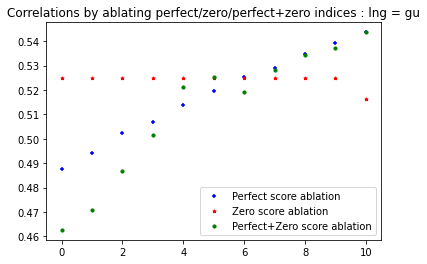

{'Perfect score count': 418, 'Zero score count': 16, 'Perfect+Zero score count': 434}


In [ ]:
# x = range(100)
# y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.scatter(x=np.arange(len(p_corr_abl_psi)),y=p_corr_abl_psi, s=10, c='b', marker="+", label='Perfect score ablation')
plt.scatter(x=np.arange(len(p_corr_abl_zsi)),y=p_corr_abl_zsi,s=10, c='r', marker="*", label='Zero score ablation')
plt.scatter(x=np.arange(len(p_corr_abl_pzsi)),y=p_corr_abl_pzsi,s=10, c='g', marker="o", label='Perfect+Zero score ablation')

plt.legend(loc='lower right');
plt.title("Correlations by ablating perfect/zero/perfect+zero indices : lng = "+lngg)
plt.show()


corr_dict = {}
corr_dict["Perfect score count"] = len(perfect_score_indices)
corr_dict["Zero score count"] = len(zero_score_indices)
corr_dict["Perfect+Zero score count"] = len(zero_perfect_score_indices)

print(corr_dict)


In [ ]:
perfect_score_indices = np.where((data['human']>=23) & (data['human']<=25))[0]  #data.index[data['human']==25].tolist()
zero_score_indices = np.where((data['human']>=0) & (data['human']<=2))[0]   #data.index[data['human']==0].tolist()
zero_perfect_score_indices = np.sort(np.unique(np.append(perfect_score_indices,zero_score_indices)))


corr_dict["Perfect score count"] = len(perfect_score_indices)
corr_dict["Zero score count"] = len(zero_score_indices)
corr_dict["Perfect+Zero score count"] = len(zero_perfect_score_indices)

print(corr_dict)

{'Perfect score count': 1121, 'Zero score count': 15, 'Perfect+Zero score count': 1136}


# Violin plots

## Violin plot depicting full range of metrics

In [ ]:
lng = 'ml'  #  language you are inferring
root_path = '/content/drive/MyDrive/Github/GenerationEval'
csv_file_path=os.path.join(root_path,'files',lng)
data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))
data_nllb.index = list(range(len(data),len(data)+200))
data_nllb['model'] = ['NLLB']*len(data_nllb)
data = data.append(data_nllb)
data.rename(columns={"Human_scores": "human"}, inplace=True)
data.rename(columns={"Computed_scores": "computed"}, inplace=True)
computed= data['computed'].to_numpy()
human= data['human'].to_numpy()
computed[computed<0]=0
human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

In [ ]:
#Print min, max also. Not removing outliers for the full range to give a clearer picture.
def standardise1(data):
  #indic_results_scaled=(indic_results - np.min(indic_results)) / (np.max(indic_results) - np.min(indic_results)) #stats.zscore(indic_results)
  data_mean, data_std = np.mean(data), np.std(data)
  data_min, data_max = np.min(data), np.max(data)
  indic_results = data
  indic_results_scaled=(indic_results - data_min ) / ( data_max - data_min ) #stats.zscore(indic_results)
  # print(data_min, data_max)
  return indic_results_scaled

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
<ipython-input-13-1ca669a1e21c>:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


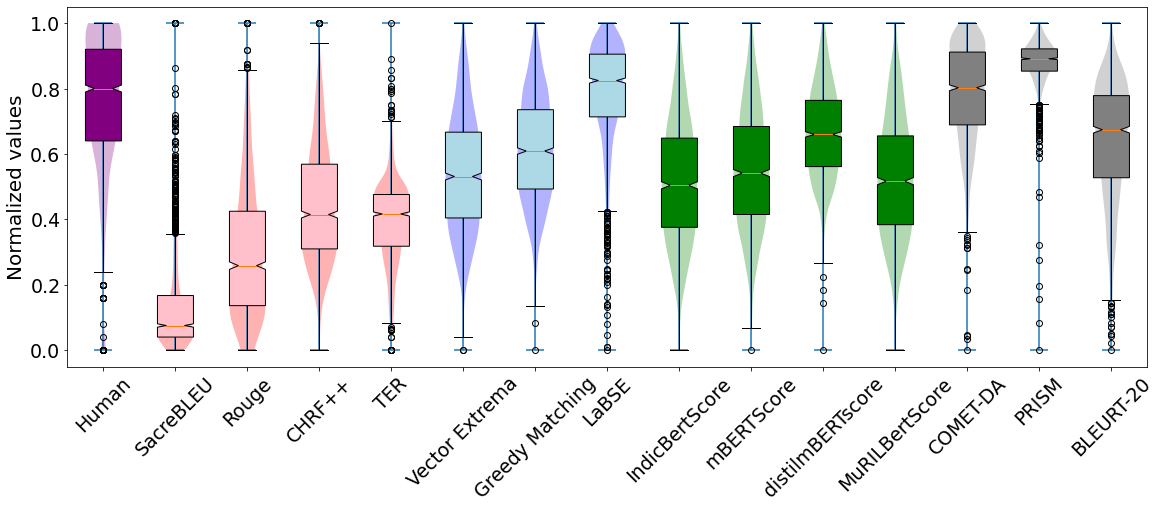

In [ ]:
#All standardised scores
data_0 = [None]*15
data_0[0] = standardise1(human)


############################################################

metrics =  ['sacrebleu_','rouge_','chrf_hf_','ter_hf_','avg_cossim_','vector_extrema_','greedy_matching_','labse_','indic_bert_','mbert_','distilbert_','muril_','comet_','prism_','bleurt20_']
metrics_nllb =  ['sacrebleu_nllb_','rouge_nllb_','chrf_hf_nllb_','ter_hf_nllb_','avg_cossim_nllb_','vector_extrema_nllb_','greedy_matching_nllb_','labse_nllb_','indic_bert_nllb_','mbert_','distilbert_','muril_nllb_','comet_nllb_','prism_nllb_','bleurt20_nllb_']
# metrics_all
mres = [None]*len(metrics) #15 is number of metrics

fig = plt.figure(figsize=(15, 5))#, sharex=True, sharey=False)
ax = fig.add_axes([0,0,1,1])

# ax = ax.ravel()
metrics =  ['sacrebleu_','rouge_','chrf_hf_','ter_hf_','vector_extrema_','greedy_matching_','labse_','indic_bert_','mbert_','distilbert_','muril_','comet_','prism_','bleurt20_']
for j,metric in enumerate(metrics):
  metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
  std_metric_results = standardise1(metric_results)
  data_0[j+1] = std_metric_results

##############################################
# x_ticks = [None]*15

XL =  ['Human','SacreBLEU','Rouge','CHRF++','TER','Vector Extrema','Greedy Matching','LaBSE','IndicBertScore','mBERTScore','distilmBERTscore','MuRILBertScore','COMET-DA','PRISM','BLEURT-20']



bplot = ax.boxplot(data_0,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     )  # will be used to label x-ticks

vplot = ax.violinplot(data_0)
plt.setp(ax, xticklabels=XL,xticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
ax.tick_params(axis='x', labelrotation=45,labelsize=19)
ax.tick_params(axis='y', labelsize=19)   # y tick labels


ax.set_ylabel('Normalized values',fontsize = 20)
# fill with colors
colors= ['purple'] + ['pink']*4 + ['lightblue']*3 + ['green']*4 +  ['gray']*3

# for k,bplot in enumerate(bplots):
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

colors1= ['purple'] + ['red']*4+ ['blue']*3 + ['green']*4 +  ['dimgrey']*3


# for k,vplot in enumerate(vplots):
for patch, color in zip(vplot['bodies'], colors1):
    patch.set_facecolor(color)

img_res_path = os.path.join('/content/drive/MyDrive/Github/GenerationEval/fullrange_plots',lng)
if not os.path.exists(img_res_path):
      os.makedirs(img_res_path)

img_file_name_path2 = os.path.join(img_res_path,lng+"_all_metrics")
plt.tight_layout()
plt.savefig(img_file_name_path2+".png",bbox_inches='tight')
plt.show()


##  Violin plot depicting metric spread for different human score intervals


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

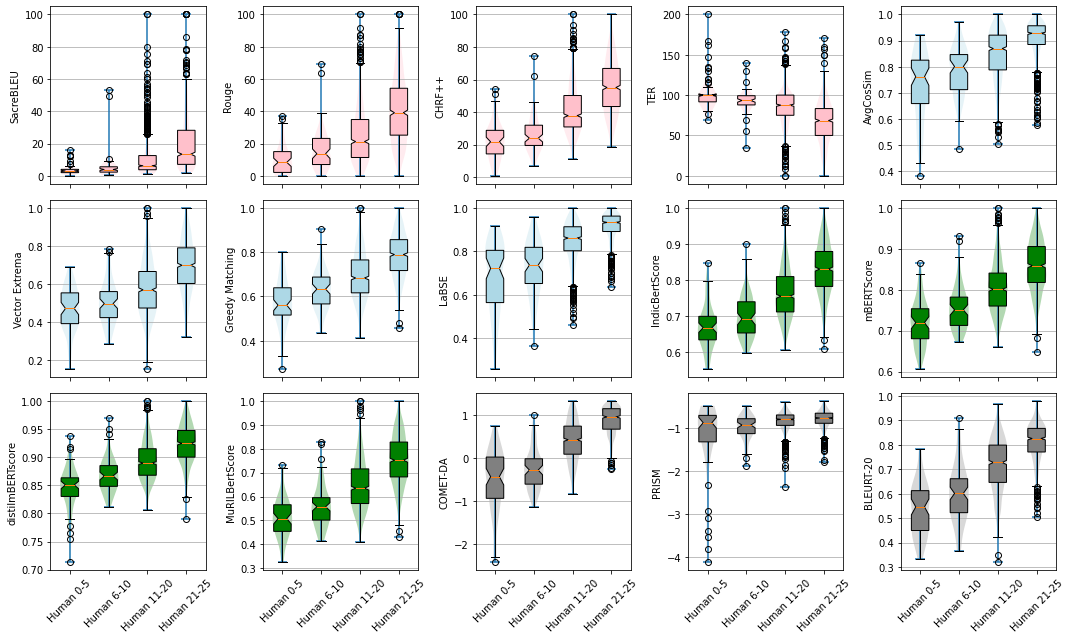

In [ ]:



lang=['ml']
for i,lng in enumerate(lang) :
  root_path = '/content/drive/MyDrive/Github/GenerationEval'
  csv_file_path=os.path.join(root_path,'files',lng)
  data = pandas.read_csv(os.path.join(csv_file_path,lng+'_mteval.csv'))
  data_nllb = pandas.read_csv(os.path.join(csv_file_path,lng+'_nllb.csv'))

  data_nllb['model'] = ['NLLB']*len(data_nllb)
  data = data.append(data_nllb)
  data.rename(columns={"Human_scores": "human"}, inplace=True)
  data.rename(columns={"Computed_scores": "computed"}, inplace=True)
  computed= data['computed'].to_numpy()
  human= data['human'].to_numpy()
  computed[computed<0]=0
  human[np.argwhere(np.isnan(human))] = computed[np.argwhere(np.isnan(human))]

  zero_to_five_indices = np.where((data['human']>=0)& (data['human']<=5))     #(a >= 6) & (a <=10)
  six_to_ten_indices = np.where((data['human']>=6) & (data['human']<=10))
  eleven_to_twenty_indices = np.where((data['human']>=11) & (data['human']<=20))
  twenty_to_twentyfive_indices = np.where((data['human']>=21) & (data['human']<=25))
  fig, ax = plt.subplots(3, 5, figsize=(15, 9),sharex=True)#, sharex=True, sharey=False)
  ax = ax.ravel()
  metrics =  ['sacrebleu_','rouge_','chrf_hf_','ter_hf_','avg_cossim_','vector_extrema_','greedy_matching_','labse_','indic_bert_','mbert_','distilbert_','muril_','comet_','prism_','bleurt20_']
  metrics_nllb =  ['sacrebleu_nllb_','rouge_nllb_','chrf_hf_nllb_','ter_hf_nllb_','avg_cossim_nllb_','vector_extrema_nllb_','greedy_matching_nllb_','labse_nllb_','indic_bert_nllb_','mbert_','distilbert_','muril_nllb_','comet_nllb_','prism_nllb_','bleurt20_nllb_']
  # metrics_all
  mres = [None]*len(metrics) #15 is number of metrics
  for j,metric in enumerate(metrics):
    metric_results = np.load(os.path.join('/content/drive/MyDrive/Github/GenerationEval/results/',lng,metric+lng+'.npy'))
    indic_results = np.load('/content/drive/MyDrive/Github/GenerationEval/results/'+lng+'/'+metrics_nllb[j]+lng+'.npy')
    metric_results = np.append(metric_results,indic_results)

    tempmres =[None]*4
    tempmres[0],tempmres[1], tempmres[2], tempmres[3] = metric_results[zero_to_five_indices] , metric_results[six_to_ten_indices], metric_results[eleven_to_twenty_indices],metric_results[twenty_to_twentyfive_indices]
    mres[j] = tempmres

  ##############################################
  x_ticks = [None]*15
  ranges =  [['0-5', '6-10', '11-20', '21-25']*15]

  # ranges = [['IndicBert Score 0-5', 'IndicBert Score 6-10', 'IndicBert Score 11-20', 'IndicBert Score 21-25'], ['COMET 0-5', 'COMET 6-10', 'COMET 11-20', 'COMET 21-25'],['SacreBLEU 0-5', 'SacreBLEU 6-10', 'SacreBLEU 11-20', 'SacreBLEU 21-25']]
  # ranges.extend([['CHRF 0-5', 'CHRF 6-10', 'CHRF 11-20', 'CHRF 21-25'], ['TER 0-5', 'TER 6-10', 'TER 11-20', 'TER 21-25'],['Vector extrema 0-5', 'Vector extrema 6-10', 'Vector extrema 11-20', 'Vector extrema 21-25']])

  YL =  ['SacreBLEU','Rouge','CHRF++','TER','AvgCosSim','Vector Extrema','Greedy Matching','LaBSE','IndicBertScore','mBERTScore','distilmBERTscore','MuRILBertScore','COMET-DA','PRISM','BLEURT-20']

  # #figsize =(15, 7))
  # ax1 = plt.subplot(111)
  # ax2 = plt.subplot(122)#, sharex = ax1)
  # ax3 = plt.subplot(133)#, sharex = ax2)

  bplots = [None]*len(mres)
  vplots = [None]*len(mres)
  for j in range(len(mres)):
      ax[j].set_xticks([])
      ax[j].tick_params(axis='x', labelrotation=45)
      bplots[j] = ax[j].boxplot(mres[j],notch=True, vert=True, patch_artist=True,)
      vplots[j] = ax[j].violinplot(mres[j])#,notch=True, vert=True, patch_artist=True,)
      ax[j].yaxis.grid(True)
      # ax[j].set_xlabel()
      ax[j].set_ylabel(YL[j])
      plt.setp(ax[j], xticklabels=['Human 0-5', 'Human 6-10', 'Human 11-20','Human 21-25'],xticks= [1,2,3,4])


  # plt.set_title('Range of metric scores in different human score intervals')

  # fill with colors
  colors = [['pink', 'pink', 'pink','pink']]*4
  colors.extend([['lightblue','lightblue','lightblue','lightblue']]*4)
  colors.extend([['green','green','green','green']]*4)
  colors.extend([['gray','gray','gray','gray']]*3)

  for k,bplot in enumerate(bplots):
    for patch, color in zip(bplot['boxes'], colors[k]):
        patch.set_facecolor(color)

  ########violin plots appending
  colors1 = [['red', 'red', 'red','red']]*4
  colors1.extend([['blue','blue','blue','blue']]*4)
  colors1.extend([['green','green','green','green']]*4)
  colors1.extend([['dimgrey','dimgrey','dimgrey','dimgrey']]*3)


  for k,vplot in enumerate(vplots):
   for patch, color in zip(vplot['bodies'], colors[k]):
       patch.set_facecolor(color)

  img_res_path = os.path.join('/content/drive/MyDrive/Github/GenerationEval/violin_plots',lng)
  if not os.path.exists(img_res_path):
        os.makedirs(img_res_path)

  img_file_name_path2 = os.path.join("/content/drive/MyDrive/Github/GenerationEval/violin_plots/",lng,lng+"_all_metrics")
  plt.tight_layout()
  plt.savefig(img_file_name_path2+".png",bbox_inches='tight')
  plt.show()


In [ ]:
# ranges = [['IndicBert Score 0-5', 'IndicBert Score 6-10', 'IndicBert Score 11-20', 'IndicBert Score 21-25'], ['COMET 0-5', 'COMET 6-10', 'COMET 11-20', 'COMET 21-25'],['SacreBLEU 0-5', 'SacreBLEU 6-10', 'SacreBLEU 11-20', 'SacreBLEU 21-25']]
# ranges.extend([['CHRF 0-5', 'CHRF 6-10', 'CHRF 11-20', 'CHRF 21-25'], ['TER 0-5', 'TER 6-10', 'TER 11-20', 'TER 21-25'],['Vector extrema 0-5', 'Vector extrema 6-10', 'Vector extrema 11-20', 'Vector extrema 21-25']])
# print(ranges)
# metrics =  ['sacrebleu_','rouge_','chrf_hf_','ter_hf_','avg_cossim_guj_','vector_extrema_','greedy_matching_','indic_bert_','mbert_','distilbert_','muril_','comet_','prism_','bleurt20_','labse_']
# metrics_nllb =  ['sacrebleu_nllb_','rouge_nllb_','chrf_hf_nllb_','ter_hf_nllb_','avg_cossim_guj_nllb_','vector_extrema_nllb_','greedy_matching_nllb_','indic_bert_nllb_','mbert_','distilbert_','muril_nllb_','comet_nllb_','prism_nllb_','bleurt20_nllb_']
# print(len(metrics) , len(metrics_nllb))
ll = [['pink', 'pink', 'pink','pink']]*10
ll.extend([['blue','blue','blue','blue']]*2)

In [ ]:
ll=[['pink', 'pink', 'pink','pink']]*10
ll.extend([['lightblue','lightblue','lightblue','lightblue']]*2)

# Heatmap Errors

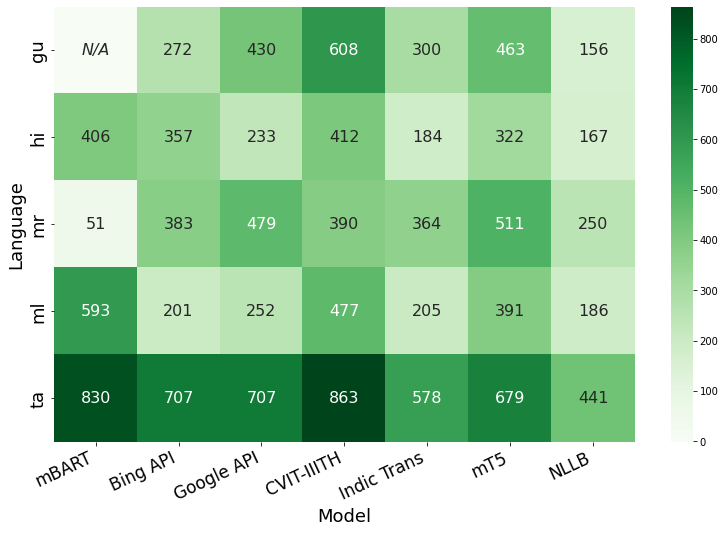

In [ ]:
data.set_index('Lang/Model', inplace=True)
# data.drop(index=['bn'],inplace =True)
fig, ax = plt.subplots(figsize=(13,8))
s= sns.heatmap(data, annot=True,fmt='g',cmap = 'Greens', annot_kws={"fontsize":16})


###newly added code
for text in ax.texts:
    text.set_size(16)
    if text.get_text() == '-1':
        text.set_size(16)
        text.set_text('N/A')
        text.set_style('italic')



#######################################
# s.set(xlabel='Model', ylabel='Language')
plt.xlabel('Model', fontsize=18)
plt.ylabel('Language', fontsize=18)

ax.set_xticklabels(['mBART',	'Bing API',	'Google API',	'CVIT-IIITH',	'Indic Trans',	'mT5',	'NLLB'], ha="right", rotation=25,fontsize = 17)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 18)

plt.savefig('/content/drive/MyDrive/Github/GenerationEval/ratio_plot/heatmap.png',bbox_inches='tight')

In [ ]:
data

,mBART,bing_api,google_api,cvit_iiith,IndicTrans_Samanantar,mT5,NLLB
Lang/Model,,,,,,,
gu,361,272,430,608,300,463,156
hi,406,357,233,412,184,322,167
mr,51,383,479,390,364,511,250
ml,593,201,252,477,205,391,186
ta,830,707,707,863,578,679,441
